In [2]:
import os
import gc
import sys
import numpy as np
import pandas as pd
import random
from glob import glob
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

try:
    import h5py
except ImportError as e:
    raise ImportError("❌ h5py is not installed or failed to load. Fix with: pip uninstall -y h5py && pip install --no-binary=h5py h5py")

# ---------------------------------------------
# CONFIGURATION
# ---------------------------------------------
GENERATED_DATA_DIR = "generated_data"  # Path to folders like data_0_exponential, etc.

# Update to reflect actual subdirectory structure if different
EMBEDDINGS_DIRS = {
    "bert":         "embeddings",
    "roberta":      "embeddings",
    "gatortron":    "embeddings",
    "t5":           "embeddings",
    "ernie":        "embeddings",
    "minilm":       "embeddings",
    "e5_small":     "embeddings_e5_small",
    "llama":        "embeddings_llama"
}

CLUSTER_RESULTS_PATH = "cluster_similarity_results.csv"

OUTPUT_DATA_DIR = "generated_data_with_clusters"  
os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

PROGRESS_FILE = "cluster_assignment_progress.csv"

# Save after every N datasets
CHECKPOINT_INTERVAL = 5

# Option to prompt if restarting from progress
ASK_ON_RESTART = True

print("✅ Configuration loaded successfully.")


✅ Configuration loaded successfully.


In [5]:
import os
import numpy as np
import pandas as pd
from glob import glob

# ✅ Update these paths to access files from synthetic data env
GENERATED_DATA_DIR = "/home/abbasali/synthetic data/generated_data"
CLUSTER_RESULTS_PATH = "/home/abbasali/synthetic data/cluster_similarity_results.csv"

def load_datasets_info(data_dir):
    """
    Return a dict of {dataset_name -> (num_rows, num_cols, num_cat_vars)} 
    for each CSV in data_dir having data_... pattern.
    """
    info_dict = {}
    csv_files = glob(os.path.join(data_dir, "*.csv"))
    
    for csv_path in csv_files:
        filename = os.path.basename(csv_path)
        dataset_name = os.path.splitext(filename)[0]  # e.g. 'data_0_exponential'
        
        df = pd.read_csv(csv_path)
        n_rows, n_cols = df.shape
        
        # Count categorical variables
        cat_count = sum(
            (df[col].dtype == "object") or (str(df[col].dtype) == "category")
            for col in df.columns
        )
        
        info_dict[dataset_name] = (n_rows, n_cols, cat_count)
    
    return info_dict

def augment_cluster_results(cluster_csv, data_info):
    """
    Adds two columns to cluster_csv: 
        - 'NumCategoricalVars'
        - 'SubjectVariableRatio' (n_rows / n_cols)
    using data_info dict from load_datasets_info().
    
    Returns a DataFrame with the new columns appended.
    """
    df_clusters = pd.read_csv(cluster_csv)
    
    # Create columns with default (in case some dataset is missing)
    df_clusters["NumCategoricalVars"] = np.nan
    df_clusters["SubjectVariableRatio"] = np.nan
    
    # Populate these columns
    for idx, row in df_clusters.iterrows():
        dataset_name = row["Dataset"]  # e.g. data_79_quadratic
        if dataset_name in data_info:
            n_rows, n_cols, cat_count = data_info[dataset_name]
            df_clusters.at[idx, "NumCategoricalVars"] = cat_count
            df_clusters.at[idx, "SubjectVariableRatio"] = n_rows / n_cols

    return df_clusters

# --- Run the data augmentation pipeline ---
data_info_dict = load_datasets_info(GENERATED_DATA_DIR)
df_clusters_aug = augment_cluster_results(CLUSTER_RESULTS_PATH, data_info_dict)

# ✅ Save output next to current working directory or wherever you like
df_clusters_aug.to_csv("cluster_similarity_results_augmented.csv", index=False)
print("✅ Augmented cluster_similarity_results.csv saved.")


✅ Augmented cluster_similarity_results.csv saved.


In [7]:
import gc
from sklearn.preprocessing import StandardScaler

def get_k_for_model(dataset_name, model_name, df_clusters_aug):
    """
    Returns the number of clusters to use for (dataset_name, model_name)
    by looking at the 'Adjusted Clusters (Embeddings)' column 
    in df_clusters_aug.
    
    If not found, defaults to some value (e.g., 5).
    """
    subset = df_clusters_aug[
        (df_clusters_aug["Dataset"] == dataset_name) &
        (df_clusters_aug["Model"] == model_name)
    ]
    if subset.empty:
        # fallback
        return 5
    else:
        return int(subset["Adjusted Clusters (Embeddings)"].values[0])

def load_embeddings(dataset_name, model_name):
    """
    Loads the embeddings for a given dataset_name and model_name
    from the correct directory. Model -> directory logic is defined 
    in EMBEDDINGS_DIRS.

    Returns a 2D numpy array [n_samples, embedding_dim].
    If model is 'llama', we handle .h5 differently.
    """
    base_dir = EMBEDDINGS_DIRS[model_name]
    
    if model_name == "llama":
        # .h5 file; search for a file containing dataset_name
        emb_files = glob(os.path.join(base_dir, f"*{dataset_name}*.h5"))
        if not emb_files:
            return None
        filepath = emb_files[0]
        with h5py.File(filepath, 'r') as h5f:
            embeddings = h5f['embeddings'][:]
    elif model_name == "e5_small":
        # .npy file with name "embeddings_e5_small_data_..._something.npy"
        emb_files = glob(os.path.join(base_dir, f"embeddings_e5_small_{dataset_name}*.npy"))
        if not emb_files:
            return None
        filepath = emb_files[0]
        embeddings = np.load(filepath)
    elif model_name == "minilm":
        emb_files = glob(os.path.join(base_dir, f"embeddings_minilm_{dataset_name}*.npy"))
        if not emb_files:
            return None
        filepath = emb_files[0]
        embeddings = np.load(filepath)
    else:
        # 'bert', 'roberta', 'gatortron', 't5', 'ernie' all typically "embeddings_{model}_{dataset}.npy"
        emb_files = glob(os.path.join(base_dir, f"embeddings_{model_name}_{dataset_name}*.npy"))
        if not emb_files:
            return None
        filepath = emb_files[0]
        embeddings = np.load(filepath)
    
    # Ensure embeddings are 2D
    if embeddings.ndim > 2:
        embeddings = embeddings.reshape(embeddings.shape[0], -1)
    
    return embeddings

def load_progress():
    """
    Loads the progress file (if it exists) and returns a set of
    (dataset_name, model_name) pairs that have been processed.
    """
    if not os.path.exists(PROGRESS_FILE):
        return set()
    progress_df = pd.read_csv(PROGRESS_FILE)
    processed_pairs = set(zip(progress_df["Dataset"], progress_df["Model"]))
    return processed_pairs

def save_progress(processed_pairs):
    """
    Saves the set of processed (dataset, model) pairs to PROGRESS_FILE
    as a CSV with columns [Dataset, Model].
    """
    df = pd.DataFrame(list(processed_pairs), columns=["Dataset", "Model"])
    df.to_csv(PROGRESS_FILE, index=False)

def ask_resume_or_restart():
    """
    If ASK_ON_RESTART is True, ask the user if they want to resume 
    or restart the entire process. If 'resume', we keep the progress.
    If 'restart', we clear it.
    """
    if not ASK_ON_RESTART:
        return  # do nothing
    
    if os.path.exists(PROGRESS_FILE):
        choice = input("Progress file detected. Type 'resume' to continue or 'restart' to delete progress: ")
        choice = choice.strip().lower()
        if choice == "restart":
            os.remove(PROGRESS_FILE)
            print("Progress has been reset.")

def assign_clusters_to_data(df_clusters_aug):
    """
    Main function that loops over each dataset CSV in generated_data,
    for each relevant model in cluster_similarity_results, 
    loads embeddings, fits KMeans with the appropriate number of clusters, 
    and assigns cluster labels back to the CSV (for each row).
    
    Outputs a new CSV in OUTPUT_DATA_DIR containing the cluster columns.
    """
    # Make sure output dir exists
    if not os.path.exists(OUTPUT_DATA_DIR):
        os.makedirs(OUTPUT_DATA_DIR)
    
    processed_pairs = load_progress()  # set of (dataset, model) done
    ask_resume_or_restart()
    
    # Re-check if user decided to "restart"
    processed_pairs = load_progress()  
    
    # We'll gather the set of (dataset, model) we need from df_clusters_aug
    needed_pairs = set(zip(df_clusters_aug["Dataset"], df_clusters_aug["Model"]))
    
    # Group cluster info by dataset, so we only open each dataset CSV once
    dataset_to_models = {}
    for ds_name, model in needed_pairs:
        dataset_to_models.setdefault(ds_name, []).append(model)
    
    csv_files = glob(os.path.join(GENERATED_DATA_DIR, "*.csv"))
    # We only handle dataset CSVs that appear in dataset_to_models
    csv_map = {}
    for path in csv_files:
        base = os.path.splitext(os.path.basename(path))[0]
        if base in dataset_to_models:
            csv_map[base] = path
    
    count_processed_in_this_batch = 0
    
    # Start iterating
    for ds_name, csv_path in csv_map.items():
        print(f"\n--- Loading dataset: {ds_name} ---")
        df_data = pd.read_csv(csv_path)
        
        # For each model that we need to process
        models_for_ds = dataset_to_models[ds_name]
        for model_name in models_for_ds:
            pair_key = (ds_name, model_name)
            if pair_key in processed_pairs:
                print(f"   Skipping {ds_name} - {model_name}, already processed.")
                continue
            
            print(f"   Processing model = {model_name} ...")
            
            # Load embeddings
            embeddings = load_embeddings(ds_name, model_name)
            if embeddings is None or embeddings.size == 0:
                print(f"   ⚠️ No embeddings found for {ds_name} (Model: {model_name}). Skipping.")
                continue
            
            # Get number of clusters from the augmented CSV
            k_clusters = get_k_for_model(ds_name, model_name, df_clusters_aug)
            print(f"   Using k = {k_clusters} for KMeans.")
            
            # Impute if needed
            embeddings = SimpleImputer(strategy="mean").fit_transform(embeddings)
            
            # Optionally scale
            embeddings = StandardScaler().fit_transform(embeddings)
            
            # Fit KMeans
            kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
            labels = kmeans.fit_predict(embeddings)
            
            # Assign cluster labels to the DataFrame
            # Ensure we have the same row count
            if len(labels) == len(df_data):
                df_data[f"cluster_{model_name}"] = labels
            else:
                print(f"   ⚠️ Embeddings length ({len(labels)}) != Data length ({len(df_data)}). Skipping.")
                continue
            
            # Mark progress
            processed_pairs.add(pair_key)
            count_processed_in_this_batch += 1
            
            # Memory cleanup
            del embeddings, kmeans, labels
            gc.collect()
        
        # After processing all models for this dataset, 
        # write out the updated DataFrame to OUTPUT_DATA_DIR
        out_csv_path = os.path.join(OUTPUT_DATA_DIR, f"{ds_name}.csv")
        df_data.to_csv(out_csv_path, index=False)
        print(f"   ✅ Wrote clusters to {out_csv_path}")
        
        # Check if we should checkpoint
        if count_processed_in_this_batch >= CHECKPOINT_INTERVAL:
            save_progress(processed_pairs)
            count_processed_in_this_batch = 0
            print(f"   [Checkpoint] Progress saved. If needed, you can safely stop and resume later.")
    
    # Final save of any leftover progress
    save_progress(processed_pairs)
    print("All done. Final progress saved.")


In [8]:
if __name__ == "__main__":
    # Step 1: Load dataset info & augment the cluster results
    data_info_dict = load_datasets_info(GENERATED_DATA_DIR)
    df_clusters_aug = augment_cluster_results(CLUSTER_RESULTS_PATH, data_info_dict)
    df_clusters_aug.to_csv("cluster_similarity_results_augmented.csv", index=False)
    print("Augmented cluster_similarity_results.csv saved.")

    # Step 2: Assign clusters
    assign_clusters_to_data(df_clusters_aug)


Augmented cluster_similarity_results.csv saved.

--- Loading dataset: data_79_quadratic ---
   Processing model = roberta ...
   ⚠️ No embeddings found for data_79_quadratic (Model: roberta). Skipping.
   Processing model = gatortron ...
   ⚠️ No embeddings found for data_79_quadratic (Model: gatortron). Skipping.
   Processing model = llama ...
   ⚠️ No embeddings found for data_79_quadratic (Model: llama). Skipping.
   Processing model = minilm ...
   ⚠️ No embeddings found for data_79_quadratic (Model: minilm). Skipping.
   Processing model = ernie ...
   ⚠️ No embeddings found for data_79_quadratic (Model: ernie). Skipping.
   Processing model = bert ...
   ⚠️ No embeddings found for data_79_quadratic (Model: bert). Skipping.
   Processing model = t5 ...
   ⚠️ No embeddings found for data_79_quadratic (Model: t5). Skipping.
   Processing model = e5_small ...
   ⚠️ No embeddings found for data_79_quadratic (Model: e5_small). Skipping.
   ✅ Wrote clusters to generated_data_with_clust

## LLama clusters

In [11]:
import os
import pandas as pd
import numpy as np
import h5py
from glob import glob
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Absolute paths for synthetic data environment
DATA_DIR = "/home/abbasali/synthetic data/generated_data"
EMBEDDINGS_LLAMA_DIR = "/home/abbasali/synthetic data/embeddings_llama"
OUTPUT_DIR = "/home/abbasali/synthetic data/generated_data_with_llama_clusters"

os.makedirs(OUTPUT_DIR, exist_ok=True)

def find_llama_embedding_file(dataset_name):
    llama_files = glob(os.path.join(EMBEDDINGS_LLAMA_DIR, f"*{dataset_name}*.h5"))
    return llama_files[0] if llama_files else None

def assign_llama_clusters_to_dataset(dataset_name, num_clusters=5):
    csv_path = os.path.join(DATA_DIR, f"{dataset_name}.csv")
    if not os.path.exists(csv_path):
        print(f"❌ No CSV found for {dataset_name}.")
        return

    df = pd.read_csv(csv_path)
    print(f"Loaded {dataset_name}.csv with shape {df.shape}.")

    llama_path = find_llama_embedding_file(dataset_name)
    if not llama_path:
        print(f"⚠️ No Llama embeddings found for {dataset_name}. Skipping.")
        return

    print(f"Loading Llama embeddings from {llama_path} ...")
    with h5py.File(llama_path, "r") as h5f:
        embeddings = h5f["embeddings"][:]

    if embeddings.ndim > 2:
        embeddings = embeddings.reshape(embeddings.shape[0], -1)

    if embeddings.shape[0] != len(df):
        print(f"⚠️ Mismatch in number of rows ({embeddings.shape[0]} vs {len(df)}). Skipping.")
        return

    embeddings = SimpleImputer(strategy="mean").fit_transform(embeddings)
    embeddings = StandardScaler().fit_transform(embeddings)

    print(f"Fitting KMeans with k={num_clusters} for {dataset_name} (Llama).")
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)

    df["cluster_llama"] = labels

    out_path = os.path.join(OUTPUT_DIR, f"{dataset_name}.csv")
    df.to_csv(out_path, index=False)
    print(f"✅ Wrote updated CSV (with cluster_llama) to {out_path}.\n")

def main():
    csv_files = glob(os.path.join(DATA_DIR, "data_*_*.csv"))
    K_DEFAULT = 5  
    
    for csv_file in csv_files:
        ds_name = os.path.splitext(os.path.basename(csv_file))[0]
        assign_llama_clusters_to_dataset(ds_name, num_clusters=K_DEFAULT)

if __name__ == "__main__":
    main()


Loaded data_79_quadratic.csv with shape (500, 35).
Loading Llama embeddings from /home/abbasali/synthetic data/embeddings_llama/embeddings_data_79_quadratic.h5 ...
Fitting KMeans with k=5 for data_79_quadratic (Llama).
✅ Wrote updated CSV (with cluster_llama) to /home/abbasali/synthetic data/generated_data_with_llama_clusters/data_79_quadratic.csv.

Loaded data_91_linear.csv with shape (500, 41).
Loading Llama embeddings from /home/abbasali/synthetic data/embeddings_llama/embeddings_data_91_linear.h5 ...
Fitting KMeans with k=5 for data_91_linear (Llama).
✅ Wrote updated CSV (with cluster_llama) to /home/abbasali/synthetic data/generated_data_with_llama_clusters/data_91_linear.csv.

Loaded data_44_exponential.csv with shape (500, 21).
Loading Llama embeddings from /home/abbasali/synthetic data/embeddings_llama/embeddings_data_44_exponential.h5 ...
Fitting KMeans with k=5 for data_44_exponential (Llama).
✅ Wrote updated CSV (with cluster_llama) to /home/abbasali/synthetic data/generated

## Merge LLama and other clusters

In [12]:
import os
import pandas as pd

# Absolute paths pointing to synthetic data environment
LLAMA_DIR = "/home/abbasali/synthetic data/generated_data_with_llama_clusters"
CLUSTERS_DIR = "/home/abbasali/synthetic data/generated_data_with_clusters"

def merge_llama_clusters():
    llama_files = [f for f in os.listdir(LLAMA_DIR) if f.endswith(".csv")]
    
    for file in llama_files:
        llama_path = os.path.join(LLAMA_DIR, file)
        clusters_path = os.path.join(CLUSTERS_DIR, file)
        
        if not os.path.exists(clusters_path):
            print(f"Skipping {file}: not found in {CLUSTERS_DIR}.")
            continue

        df_llama = pd.read_csv(llama_path)
        df_clusters = pd.read_csv(clusters_path)
        
        if "cluster_llama" not in df_llama.columns:
            print(f"Skipping {file}: no 'cluster_llama' column found.")
            continue
        
        if len(df_llama) != len(df_clusters):
            print(f"Skipping {file}: row count mismatch ({len(df_llama)} vs {len(df_clusters)}).")
            continue
        
        df_clusters["cluster_llama"] = df_llama["cluster_llama"].values
        df_clusters.to_csv(clusters_path, index=False)
        print(f"✅ Appended cluster_llama to {clusters_path}.")

if __name__ == "__main__":
    merge_llama_clusters()


✅ Appended cluster_llama to /home/abbasali/synthetic data/generated_data_with_clusters/data_79_quadratic.csv.
✅ Appended cluster_llama to /home/abbasali/synthetic data/generated_data_with_clusters/data_91_linear.csv.
✅ Appended cluster_llama to /home/abbasali/synthetic data/generated_data_with_clusters/data_44_exponential.csv.
✅ Appended cluster_llama to /home/abbasali/synthetic data/generated_data_with_clusters/data_42_linear.csv.
✅ Appended cluster_llama to /home/abbasali/synthetic data/generated_data_with_clusters/data_88_exponential.csv.
✅ Appended cluster_llama to /home/abbasali/synthetic data/generated_data_with_clusters/data_43_linear.csv.
✅ Appended cluster_llama to /home/abbasali/synthetic data/generated_data_with_clusters/data_48_cubic.csv.
✅ Appended cluster_llama to /home/abbasali/synthetic data/generated_data_with_clusters/data_13_cubic.csv.
✅ Appended cluster_llama to /home/abbasali/synthetic data/generated_data_with_clusters/data_33_quadratic.csv.
✅ Appended cluster_llam

## LLM assisted vs unassisted machine learning linear regression step one linear regression

In [14]:
import os
import numpy as np
import pandas as pd
from glob import glob

# For regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# For transformations
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Added StandardScaler for numeric
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# SHAP for feature importance
import shap

# -----------------------------------------------------
# CONFIG
# -----------------------------------------------------
DATA_DIR =  "/home/abbasali/synthetic data/generated_data_with_clusters"    # Directory with your CSV data
OUTPUT_DIR = "numeric_x3_results"            # Where partial outputs go
UNASSISTED_FILE = "unassisted_model_results.csv"  # Final results
RANDOM_SEED = 42
N_BOOTSTRAP_SAMPLES = 100 # Number of bootstrap samples for evaluation

REG_MODELS = {
    "LinearReg": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED),
    "GradientBoost": GradientBoostingRegressor(random_state=RANDOM_SEED)
}

# Ensure output directory exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

def build_preprocessor(numeric_cols, cat_cols):
    """
    Builds preprocessing pipelines:
      1. Numeric: median imputer + StandardScaler
      2. Categorical: most frequent imputer + OneHotEncoder
    """
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()) # Added StandardScaler
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ])

    column_tf = ColumnTransformer([
        ("num", numeric_pipeline, numeric_cols),
        ("cat", cat_pipeline, cat_cols)
    ], remainder='passthrough') # Keep other columns if any, though not expected here
    return column_tf

def bootstrap_evaluate_regression_models(X, y, numeric_cols, cat_cols, n_bootstrap_samples=N_BOOTSTRAP_SAMPLES):
    """
    Evaluates models using bootstrapping to get more robust performance estimates
    and their variability (mean and std dev of R2 and MAE).

    Returns a dictionary of lists for each metric.
    """
    model_r2_scores = {name: [] for name in REG_MODELS.keys()}
    model_mae_scores = {name: [] for name in REG_MODELS.keys()}

    # Initialize a placeholder for the best pipeline found across all bootstraps
    # This will be used for SHAP, so we need one that's representative or the "last best"
    best_pipeline_overall = None
    best_overall_score = -np.inf # For R2, higher is better
    
    for i in range(n_bootstrap_samples):
        # Set a unique seed for each bootstrap iteration for reproducibility of the iteration
        np.random.seed(RANDOM_SEED + i) 
        
        # Create a bootstrap sample (resampling with replacement)
        bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
        X_bootstrap = X.iloc[bootstrap_indices].copy()
        y_bootstrap = y[bootstrap_indices].copy()

        # Split bootstrap sample into train and test
        X_train_bs, X_test_bs, y_train_bs, y_test_bs = train_test_split(
            X_bootstrap, y_bootstrap, test_size=0.3, random_state=RANDOM_SEED + i # Use iteration specific seed for split
        )

        preprocessor = build_preprocessor(numeric_cols, cat_cols)

        current_best_model_name = None
        current_best_model_score = None
        current_best_model_obj = None

        for model_name, model_obj in REG_MODELS.items():
            # Build the full pipeline for this model and fit it on the training data
            # Preprocessor is now fitted *within* the loop on the training fold
            full_pipeline = Pipeline([
                ("preprocessor", preprocessor),
                ("model", model_obj)
            ])
            
            # Fit the entire pipeline on the training data of the current bootstrap sample
            full_pipeline.fit(X_train_bs, y_train_bs)
            y_pred_bs = full_pipeline.predict(X_test_bs)

            r2 = r2_score(y_test_bs, y_pred_bs)
            mae = mean_absolute_error(y_test_bs, y_pred_bs)
            
            model_r2_scores[model_name].append(r2)
            model_mae_scores[model_name].append(mae)

            # Track the best model/pipeline from the last bootstrap sample for SHAP
            # This is a simplification; for production, you might train SHAP on the
            # best model identified from the *average* performance across bootstraps,
            # or train a final model on the full dataset.
            if model_name == "LinearReg":
                # For R2, higher is better
                if current_best_model_score is None or r2 > current_best_model_score:
                    current_best_model_score = r2
                    current_best_model_name = model_name
                    current_best_model_obj = full_pipeline # Store the full pipeline
            else:
                # For MAE, lower is better
                if current_best_model_score is None or mae < current_best_model_score:
                    current_best_model_score = mae
                    current_best_model_name = model_name
                    current_best_model_obj = full_pipeline # Store the full pipeline
        
        # Update the overall best pipeline based on R2 for simplicity for SHAP (arbitrary choice)
        # You might want a more sophisticated selection logic if you need the "absolute" best.
        if current_best_model_score is not None and current_best_model_score > best_overall_score:
            best_overall_score = current_best_model_score
            best_pipeline_overall = current_best_model_obj # Store the best pipeline encountered

    # Calculate mean and standard deviation for each metric
    mean_r2_scores = {name: np.mean(scores) for name, scores in model_r2_scores.items()}
    std_r2_scores = {name: np.std(scores) for name, scores in model_r2_scores.items()}
    
    mean_mae_scores = {name: np.mean(scores) for name, scores in model_mae_scores.items()}
    std_mae_scores = {name: np.std(scores) for name, scores in model_mae_scores.items()}

    # Determine the single "best" model based on mean R2 for reporting and SHAP
    # (If using MAE for RandomForest/GradientBoost, this logic would need to change)
    best_model_name_final = max(mean_r2_scores, key=mean_r2_scores.get)
    best_score_final = mean_r2_scores[best_model_name_final]

    return {
        "mean_r2": mean_r2_scores,
        "std_r2": std_r2_scores,
        "mean_mae": mean_mae_scores,
        "std_mae": std_mae_scores,
        "best_model_name": best_model_name_final,
        "best_score": best_score_final, # This is the mean R2 for the best model
        "best_pipeline_for_shap": best_pipeline_overall # Use the pipeline from an iteration for SHAP
    }


def compute_shap_top_features(best_pipeline, X, numeric_cols, cat_cols, top_n=10):
    """
    Computes top features using SHAP for feature importance.
    The pipeline is expected to be already fitted.
    """
    prep = best_pipeline.named_steps["preprocessor"]
    model = best_pipeline.named_steps["model"]

    # Transform X using the fitted preprocessor from the pipeline
    X_enc = prep.transform(X)
    if hasattr(X_enc, "toarray"):
        X_enc = X_enc.toarray()
    X_enc = X_enc.astype(np.float32)

    # Extract feature names
    feature_names = []
    try:
        # Get names from numeric transformer
        numeric_names_ = prep.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numeric_cols)
        feature_names.extend(numeric_names_)
    except AttributeError:
        # Fallback if StandardScaler doesn't have get_feature_names_out (older versions)
        feature_names.extend(numeric_cols)

    try:
        # Get names from categorical transformer
        cat_ohe = prep.named_transformers_['cat'].named_steps['ohe']
        cat_feature_names = cat_ohe.get_feature_names_out(cat_cols)
        feature_names.extend(cat_feature_names)
    except AttributeError:
        # Fallback if OneHotEncoder doesn't have get_feature_names_out (older versions)
        # This will just use original cat_cols, not the one-hot encoded names
        print("Warning: Could not get OHE feature names, using original categorical column names.")
        feature_names.extend(cat_cols)


    if len(feature_names) != X_enc.shape[1]:
        print(f"Warning: Mismatch between feature names ({len(feature_names)}) and transformed data columns ({X_enc.shape[1]}). Using generic names for SHAP.")
        feature_names = [f"feature_{i}" for i in range(X_enc.shape[1])]


    # Decide SHAP explainer
    model_type = type(model).__name__
    if model_type in ["RandomForestRegressor", "GradientBoostingRegressor"]:
        explainer = shap.TreeExplainer(model, feature_perturbation="interventional")
        shap_values = explainer.shap_values(X_enc, check_additivity=False)
    elif model_type == "LinearRegression":
        # For Linear Regression, passing the full transformed dataset as background is fine
        explainer = shap.LinearExplainer(model, X_enc)
        shap_values = explainer.shap_values(X_enc)
    else:
        # KernelExplainer needs a background dataset sample
        background = shap.sample(X_enc, min(100, X_enc.shape[0]))
        explainer = shap.KernelExplainer(model.predict, background)
        shap_values = explainer.shap_values(X_enc)

    # Compute mean SHAP values
    if isinstance(shap_values, list): # For multi-output models, if applicable (less common for basic regression)
        abs_shap = np.mean([np.abs(sv) for sv in shap_values], axis=0)
    else:
        abs_shap = np.abs(shap_values)

    mean_shap = abs_shap.mean(axis=0)
    sorted_idx = np.argsort(mean_shap)[::-1]
    top_n_idx = sorted_idx[:top_n]
    
    # Ensure top_n_idx does not exceed feature_names length
    top_n_idx = [idx for idx in top_n_idx if idx < len(feature_names)]

    top_features = [feature_names[i] for i in top_n_idx]
    return top_features

def main():
    csv_files = glob(os.path.join(DATA_DIR, "*.csv"))
    if not csv_files:
        print(f"No CSV files found in {DATA_DIR}. Please check the DATA_DIR path.")
        return

    all_results = []

    for path in csv_files:
        ds_name = os.path.splitext(os.path.basename(path))[0]
        print(f"\n--- Processing dataset: {ds_name} ---")
        df = pd.read_csv(path)

        # Convert target and predictors to numeric
        for col in ["x1", "x2", "x3"]:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

        # Drop missing target variable x3
        if "x3" not in df.columns:
            print(f"    Skipping {ds_name}: no x3 found.")
            continue
        df = df.dropna(subset=["x3"]).copy() # Use .copy() to avoid SettingWithCopyWarning
        if df.empty:
            print(f"    Skipping {ds_name}: x3 all NaN after drop.")
            continue

        # Identify categorical columns (starting with 'cat')
        cat_cols = [c for c in df.columns if c.startswith("cat")]
        for c in cat_cols:
            df[c] = df[c].astype("category")

        # Remove rows missing x1 or x2 (features required for the model)
        df = df.dropna(subset=["x1", "x2"]).copy() # Use .copy()
        if df.empty:
            print(f"    Skipping {ds_name}: x1 or x2 all NaN after drop.")
            continue

        # Identify numeric features
        numeric_cols = ["x1", "x2"]

        X = df[numeric_cols + cat_cols].copy()
        y = df["x3"].values

        # Check for sufficient data after all filtering
        if len(X) < 10: # Arbitrary minimum data points
            print(f"    Skipping {ds_name}: Not enough data points ({len(X)}) after preprocessing.")
            continue

        # Evaluate models using bootstrapping
        evaluation_results = bootstrap_evaluate_regression_models(
            X, y, numeric_cols, cat_cols, n_bootstrap_samples=N_BOOTSTRAP_SAMPLES
        )
        
        # Extract best model name and its mean score from bootstrap results
        best_model_name = evaluation_results["best_model_name"]
        best_score_val = evaluation_results["best_score"] # This is the mean R2 for the best model

        # Print detailed bootstrap results
        print(f"\n--- Bootstrap Evaluation Results for {ds_name} ---")
        for model_name in REG_MODELS.keys():
            mean_r2 = evaluation_results["mean_r2"][model_name]
            std_r2 = evaluation_results["std_r2"][model_name]
            mean_mae = evaluation_results["mean_mae"][model_name]
            std_mae = evaluation_results["std_mae"][model_name]
            print(f"  Model: {model_name}")
            print(f"    Mean R2: {mean_r2:.4f} (Std: {std_r2:.4f})")
            print(f"    Mean MAE: {mean_mae:.4f} (Std: {std_mae:.4f})")
        print(f"  Overall Best Model (based on R2): {best_model_name}, Mean R2 = {best_score_val:.4f}")

        # Use the "best_pipeline_for_shap" (last best pipeline from a bootstrap iter) for SHAP
        best_pipeline_for_shap = evaluation_results["best_pipeline_for_shap"]
        
        # It's crucial that best_pipeline_for_shap is not None before calling compute_shap_top_features
        if best_pipeline_for_shap is None:
            print(f"    Skipping SHAP for {ds_name}: No valid pipeline found for SHAP calculation.")
            top_feats_str = "N/A"
        else:
            try:
                top_feats = compute_shap_top_features(best_pipeline_for_shap, X, numeric_cols, cat_cols, top_n=10)
                top_feats_str = ", ".join(top_feats)
                print(f"  Top 10 SHAP features (from a representative pipeline): {top_feats_str}")
            except Exception as e:
                print(f"    Error computing SHAP for {ds_name}: {e}")
                top_feats_str = "Error during SHAP computation"


        all_results.append({
            "Dataset": ds_name,
            "BestModel (Mean R2)": best_model_name,
            "Mean_R2": best_score_val,
            "R2_StdDev": evaluation_results["std_r2"][best_model_name],
            "MAE_Mean_LinearReg": evaluation_results["mean_mae"]["LinearReg"], # Include specific MAE for all models
            "MAE_StdDev_LinearReg": evaluation_results["std_mae"]["LinearReg"],
            "MAE_Mean_RandomForest": evaluation_results["mean_mae"]["RandomForest"],
            "MAE_StdDev_RandomForest": evaluation_results["std_mae"]["RandomForest"],
            "MAE_Mean_GradientBoost": evaluation_results["mean_mae"]["GradientBoost"],
            "MAE_StdDev_GradientBoost": evaluation_results["std_mae"]["GradientBoost"],
            "TopFeatures": top_feats_str
        })

    results_df = pd.DataFrame(all_results)
    results_df.to_csv(os.path.join(OUTPUT_DIR, UNASSISTED_FILE), index=False)
    print(f"\n✅ All results saved to {OUTPUT_DIR}/{UNASSISTED_FILE}.")

if __name__ == "__main__":
    main()


--- Processing dataset: data_79_quadratic ---

--- Bootstrap Evaluation Results for data_79_quadratic ---
  Model: LinearReg
    Mean R2: -0.0002 (Std: 0.0809)
    Mean MAE: 26.5170 (Std: 1.5215)
  Model: RandomForest
    Mean R2: 0.5860 (Std: 0.0773)
    Mean MAE: 14.4466 (Std: 1.7646)
  Model: GradientBoost
    Mean R2: 0.7165 (Std: 0.0611)
    Mean MAE: 12.1623 (Std: 1.3606)
  Overall Best Model (based on R2): GradientBoost, Mean R2 = 0.7165
  Top 10 SHAP features (from a representative pipeline): x2, x1, cat25_Category_25_B, cat25_Category_25_A, cat4_Category_4_B, cat4_Category_4_A, cat9_Category_9_B, cat9_Category_9_A, cat22_Category_22_A, cat22_Category_22_B

--- Processing dataset: data_91_linear ---

--- Bootstrap Evaluation Results for data_91_linear ---
  Model: LinearReg
    Mean R2: 0.9418 (Std: 0.0092)
    Mean MAE: 3.9416 (Std: 0.2651)
  Model: RandomForest
    Mean R2: 0.4591 (Std: 0.0760)
    Mean MAE: 11.0760 (Std: 1.0155)
  Model: GradientBoost
    Mean R2: 0.5401 (S

## Linear regression for LLM assisted and unassisted analysis

In [32]:
import os
import numpy as np
import pandas as pd
from glob import glob
import csv # For writing progress file

# For regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# For transformations
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# SHAP for feature importance (kept for potential future use, not directly in main loop)
import shap

# -----------------------------------------------------
# CONFIG
# -----------------------------------------------------
# IMPORTANT: Adjust DATA_DIR to your actual path within WSL if running from WSL terminal
DATA_DIR = "/home/abbasali/synthetic data/generated_data_with_clusters"
# Output file will be in the directory where the script is run
OUTPUT_FILE = "combined_regression_results.csv"
PROGRESS_FILE = "regression_progress.csv" # File to track completed datasets
RANDOM_SEED = 42
N_BOOTSTRAP_SAMPLES = 100 # Number of bootstrap samples for evaluation

REG_MODELS = {
    "LinearReg": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED),
    "GradientBoost": GradientBoostingRegressor(random_state=RANDOM_SEED)
}

# --- Helper Functions ---

def build_preprocessor(numeric_cols, cat_cols):
    """
    Builds preprocessing pipelines:
      1. Numeric: median imputer + StandardScaler
      2. Categorical: most frequent imputer + OneHotEncoder
    """
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) # sparse_output=False for SVI calculation
    ])

    column_tf = ColumnTransformer([
        ("num", numeric_pipeline, numeric_cols),
        ("cat", cat_pipeline, cat_cols)
    ], remainder='passthrough')
    return column_tf

def get_transformed_feature_count(preprocessor, X, numeric_cols, cat_cols):
    """
    Estimates the number of features after transformation by fitting a dummy pipeline.
    This is needed for SVI calculation before actual model training.
    """
    # Create a dummy DataFrame with one row to get feature count
    # This avoids fitting the preprocessor on the whole X just for count
    if X.empty:
        return 0
    
    # Ensure dummy_X has the same columns as X
    dummy_X = pd.DataFrame(columns=X.columns)
    
    # Populate dummy_X with one row, ensuring correct dtypes for preprocessor
    dummy_row_data = {}
    for col in X.columns:
        if col in numeric_cols:
            dummy_row_data[col] = [X[col].iloc[0] if not X[col].empty and pd.notna(X[col].iloc[0]) else 0.0]
        elif col in cat_cols:
            dummy_row_data[col] = [X[col].iloc[0] if not X[col].empty and pd.notna(X[col].iloc[0]) else 'dummy_cat']
        else: # For 'passthrough' columns
            dummy_row_data[col] = [X[col].iloc[0] if not X[col].empty and pd.notna(X[col].iloc[0]) else 0]

    # Handle case where X is empty or contains only NaNs for a column
    if not dummy_row_data: # If no columns could be initialized
        return 0

    dummy_df = pd.DataFrame(dummy_row_data)
    
    # Ensure categorical columns are 'category' dtype in dummy_df
    for col in cat_cols:
        if col in dummy_df.columns:
            dummy_df[col] = dummy_df[col].astype('category')

    try:
        # Fit on a small sample to get feature names/count
        # Use a small subset of X if X is large, or just the dummy_df
        transformed_sample = preprocessor.fit_transform(dummy_df)
        if hasattr(transformed_sample, 'shape'):
            return transformed_sample.shape[1]
        else:
            return len(transformed_sample) # For single-row output
    except Exception as e:
        print(f"Warning: Could not determine transformed feature count: {e}")
        return 0


def bootstrap_evaluate_regression_models(X, y, numeric_cols, cat_cols, n_bootstrap_samples=N_BOOTSTRAP_SAMPLES):
    """
    Evaluates models using bootstrapping to get more robust performance estimates
    and their variability (mean and std dev of R2 and MAE).

    Returns a dictionary of mean/std scores and a representative pipeline for SHAP.
    """
    model_r2_scores = {name: [] for name in REG_MODELS.keys()}
    model_mae_scores = {name: [] for name in REG_MODELS.keys()}

    best_pipeline_overall = None
    best_overall_r2 = -np.inf # For R2, higher is better

    # Check for sufficient data for splitting
    if len(X) < 2 or len(y) < 2:
        print("      Not enough samples for bootstrap evaluation.")
        return None

    for i in range(n_bootstrap_samples):
        np.random.seed(RANDOM_SEED + i) # Set a unique seed for each bootstrap iteration
        
        # Create a bootstrap sample (resampling with replacement)
        bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
        X_bootstrap = X.iloc[bootstrap_indices].copy()
        y_bootstrap = y[bootstrap_indices].copy()

        # Split bootstrap sample into train and test
        # Ensure enough samples for split
        if len(X_bootstrap) < 2 or len(y_bootstrap) < 2:
            continue # Skip this bootstrap iteration if data is too small

        X_train_bs, X_test_bs, y_train_bs, y_test_bs = train_test_split(
            X_bootstrap, y_bootstrap, test_size=0.3, random_state=RANDOM_SEED + i
        )
        
        # Ensure training and test sets are not empty after split
        if X_train_bs.empty or X_test_bs.empty or len(y_train_bs) == 0 or len(y_test_bs) == 0:
            continue # Skip if split results in empty sets

        preprocessor = build_preprocessor(numeric_cols, cat_cols)

        current_best_model_score_r2 = -np.inf # Track best R2 for this bootstrap iteration
        current_best_pipeline_this_iter = None

        for model_name, model_obj in REG_MODELS.items():
            full_pipeline = Pipeline([
                ("preprocessor", preprocessor),
                ("model", model_obj)
            ])
            
            try:
                full_pipeline.fit(X_train_bs, y_train_bs)
                y_pred_bs = full_pipeline.predict(X_test_bs)

                r2 = r2_score(y_test_bs, y_pred_bs)
                mae = mean_absolute_error(y_test_bs, y_pred_bs)
                
                model_r2_scores[model_name].append(r2)
                model_mae_scores[model_name].append(mae)

                # Update best pipeline for SHAP based on R2 (arbitrary choice for SHAP representation)
                if r2 > current_best_model_score_r2:
                    current_best_model_score_r2 = r2
                    current_best_pipeline_this_iter = full_pipeline # Store the full pipeline
            except Exception as e:
                # print(f"      Model {model_name} failed in bootstrap {i+1}: {e}")
                pass # Skip this model for this iteration if it fails

        # Update the overall best pipeline if this iteration yielded a better R2
        if current_best_pipeline_this_iter is not None and current_best_model_score_r2 > best_overall_r2:
            best_overall_r2 = current_best_model_score_r2
            best_pipeline_overall = current_best_pipeline_this_iter

    # Calculate mean and standard deviation for each metric, handling empty lists
    mean_r2_scores = {name: np.mean(scores) if scores else np.nan for name, scores in model_r2_scores.items()}
    std_r2_scores = {name: np.std(scores) if scores else np.nan for name, scores in model_r2_scores.items()}
    
    mean_mae_scores = {name: np.mean(scores) if scores else np.nan for name, scores in model_mae_scores.items()}
    std_mae_scores = {name: np.std(scores) if scores else np.nan for name, scores in model_mae_scores.items()}

    # Determine the single "best" model based on mean R2 for reporting
    best_model_name_final = None
    best_score_final = np.nan
    if any(pd.notna(list(mean_r2_scores.values()))): # Check if any R2 scores are not NaN
        best_model_name_final = max(mean_r2_scores, key=lambda k: mean_r2_scores[k] if pd.notna(mean_r2_scores[k]) else -np.inf)
        best_score_final = mean_r2_scores[best_model_name_final]

    return {
        "mean_r2": mean_r2_scores,
        "std_r2": std_r2_scores,
        "mean_mae": mean_mae_scores,
        "std_mae": std_mae_scores,
        "best_model_name": best_model_name_final,
        "best_score": best_score_final,
        "best_pipeline_for_shap": best_pipeline_overall
    }


def compute_shap_top_features(best_pipeline, X, numeric_cols, cat_cols, top_n=10):
    """
    Computes top features using SHAP for feature importance.
    The pipeline is expected to be already fitted.
    """
    if best_pipeline is None:
        return []

    prep = best_pipeline.named_steps["preprocessor"]
    model = best_pipeline.named_steps["model"]

    # Transform X using the fitted preprocessor from the pipeline
    X_enc = prep.transform(X)
    if hasattr(X_enc, "toarray"):
        X_enc = X_enc.toarray()
    X_enc = X_enc.astype(np.float32)

    # Extract feature names
    feature_names = []
    try:
        # Get names from numeric transformer
        # Use get_feature_names_out if available, otherwise fall back to original names
        numeric_transformer = prep.named_transformers_['num']
        if hasattr(numeric_transformer.named_steps['scaler'], 'get_feature_names_out'):
            numeric_names_ = numeric_transformer.named_steps['scaler'].get_feature_names_out(numeric_cols)
        else:
            numeric_names_ = numeric_cols # Fallback for older sklearn versions
        feature_names.extend(numeric_names_)
    except Exception:
        feature_names.extend(numeric_cols) # Fallback in case of any error

    try:
        # Get names from categorical transformer
        cat_ohe = prep.named_transformers_['cat'].named_steps['ohe']
        if hasattr(cat_ohe, 'get_feature_names_out'):
            cat_feature_names = cat_ohe.get_feature_names_out(cat_cols)
        else:
            cat_feature_names = [f"{col}_{cat}" for col in cat_ohe.feature_names_in_ for cat in cat_ohe.categories_[cat_ohe.feature_names_in_.tolist().index(col)]] # Manual reconstruction
        feature_names.extend(cat_feature_names)
    except Exception:
        print("Warning: Could not get OHE feature names, using original categorical column names as fallback.")
        feature_names.extend(cat_cols) # Fallback

    if len(feature_names) != X_enc.shape[1]:
        print(f"Warning: Mismatch between feature names ({len(feature_names)}) and transformed data columns ({X_enc.shape[1]}). Using generic names for SHAP.")
        feature_names = [f"feature_{i}" for i in range(X_enc.shape[1])]


    # Decide SHAP explainer
    model_type = type(model).__name__
    if model_type in ["RandomForestRegressor", "GradientBoostingRegressor"]:
        explainer = shap.TreeExplainer(model, feature_perturbation="interventional")
        shap_values = explainer.shap_values(X_enc, check_additivity=False)
    elif model_type == "LinearRegression":
        explainer = shap.LinearExplainer(model, X_enc)
        shap_values = explainer.shap_values(X_enc)
    else:
        # KernelExplainer needs a background dataset sample
        background = shap.sample(X_enc, min(100, X_enc.shape[0]))
        explainer = shap.KernelExplainer(model.predict, background)
        shap_values = explainer.shap_values(X_enc)

    # Compute mean SHAP values
    if isinstance(shap_values, list):
        abs_shap = np.mean([np.abs(sv) for sv in shap_values], axis=0)
    else:
        abs_shap = np.abs(shap_values)

    mean_shap = abs_shap.mean(axis=0)
    sorted_idx = np.argsort(mean_shap)[::-1]
    top_n_idx = sorted_idx[:top_n]
    
    # Ensure top_n_idx does not exceed feature_names length
    top_n_idx = [idx for idx in top_n_idx if idx < len(feature_names)]

    top_features = [feature_names[i] for i in top_n_idx]
    return top_features

def get_completed_datasets(progress_file):
    """Reads the progress file and returns a set of completed dataset names."""
    completed = set()
    if os.path.exists(progress_file):
        try:
            df_progress = pd.read_csv(progress_file)
            completed = set(df_progress['Dataset'].unique())
            print(f"Resuming: Found {len(completed)} completed datasets in {progress_file}.")
        except pd.errors.EmptyDataError:
            print(f"Progress file {progress_file} is empty, starting fresh.")
        except Exception as e:
            print(f"Error reading progress file {progress_file}: {e}. Starting fresh.")
    return completed

def append_results_to_csv(results_list, output_file):
    """Appends a list of dictionaries (results for one dataset) to a CSV."""
    if not results_list:
        return

    df_to_append = pd.DataFrame(results_list)
    if not os.path.exists(output_file):
        df_to_append.to_csv(output_file, index=False, mode='w')
    else:
        df_to_append.to_csv(output_file, index=False, mode='a', header=False)

def main():
    # Ensure the output directory for results (current working directory) exists
    # This is implicitly handled as files are written to current dir.

    csv_files = glob(os.path.join(DATA_DIR, "*.csv"))
    if not csv_files:
        print(f"No CSV files found in {DATA_DIR}. Please check the DATA_DIR path.")
        return

    # Read already completed datasets from the progress file
    completed_datasets = get_completed_datasets(PROGRESS_FILE)

    all_results_buffer = [] # Buffer to hold results for one dataset before writing to CSV

    for path in csv_files:
        ds_name = os.path.splitext(os.path.basename(path))[0]
        
        if ds_name in completed_datasets:
            print(f"\n--- Skipping already processed dataset: {ds_name} ---")
            continue

        print(f"\n--- Processing dataset: {ds_name} ---")
        df = pd.read_csv(path)

        # Convert target and predictors to numeric
        for col in ["x1", "x2", "x3"]:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

        # Drop missing target variable x3
        if "x3" not in df.columns:
            print(f"    Skipping {ds_name}: no x3 found.")
            continue
        df_cleaned = df.dropna(subset=["x3"]).copy() # Use .copy() to avoid SettingWithCopyWarning
        if df_cleaned.empty:
            print(f"    Skipping {ds_name}: x3 all NaN after drop.")
            continue

        # Identify categorical columns (starting with 'cat')
        cat_cols_all = [c for c in df_cleaned.columns if c.startswith("cat")]
        for c in cat_cols_all:
            df_cleaned[c] = df_cleaned[c].astype("category")

        # Remove rows missing x1 or x2 (features required for the model)
        df_cleaned = df_cleaned.dropna(subset=["x1", "x2"]).copy()
        if df_cleaned.empty:
            print(f"    Skipping {ds_name}: x1 or x2 all NaN after drop.")
            continue

        # Identify numeric features
        numeric_cols_base = ["x1", "x2"]
        
        # Identify LLM cluster columns
        llm_cluster_cols = [c for c in df_cleaned.columns if c.startswith("cluster_")]
        
        current_dataset_results = [] # Collect results for this specific dataset

        # --- UNASSISTED ANALYSIS ---
        print(f"  Evaluating Unassisted Model for {ds_name}...")
        # Features for unassisted: numeric_cols_base + other 'cat' columns (excluding all cluster_ columns)
        unassisted_feature_cols = [col for col in df_cleaned.columns if col in numeric_cols_base or (col.startswith('cat') and col not in llm_cluster_cols)]
        
        X_unassisted = df_cleaned[unassisted_feature_cols].copy()
        y_unassisted = df_cleaned["x3"].values

        # Check for sufficient data
        if len(X_unassisted) < 10 or len(np.unique(y_unassisted)) < 2:
            print(f"    Skipping Unassisted for {ds_name}: Not enough data or unique classes after filtering.")
        else:
            # Calculate SVI for unassisted
            preprocessor_unassisted_svi = build_preprocessor(numeric_cols_base, [c for c in unassisted_feature_cols if c.startswith('cat')])
            num_transformed_features_unassisted = get_transformed_feature_count(preprocessor_unassisted_svi, X_unassisted, numeric_cols_base, [c for c in unassisted_feature_cols if c.startswith('cat')])
            svi_unassisted = len(X_unassisted) / num_transformed_features_unassisted if num_transformed_features_unassisted > 0 else np.inf

            eval_results_unassisted = bootstrap_evaluate_regression_models(
                X_unassisted, y_unassisted, numeric_cols_base, [c for c in unassisted_feature_cols if c.startswith('cat')], N_BOOTSTRAP_SAMPLES
            )
            
            if eval_results_unassisted is not None and eval_results_unassisted["best_model_name"] is not None:
                for model_name in REG_MODELS.keys():
                    current_dataset_results.append({
                        "Dataset": ds_name,
                        "AnalysisType": "Unassisted",
                        "LLM_Cluster_Used": "N/A", # Indicate no specific cluster was used as feature
                        "Model": model_name,
                        "Mean_R2": eval_results_unassisted["mean_r2"].get(model_name, np.nan),
                        "R2_StdDev": eval_results_unassisted["std_r2"].get(model_name, np.nan),
                        "Mean_MAE": eval_results_unassisted["mean_mae"].get(model_name, np.nan),
                        "MAE_StdDev": eval_results_unassisted["std_mae"].get(model_name, np.nan),
                        "SVI": svi_unassisted,
                        "TopFeatures": "N/A" # SHAP for unassisted can be added if needed, but not requested here
                    })
                print(f"  Unassisted Model evaluation complete for {ds_name}.")
            else:
                print(f"  Unassisted Model evaluation failed for {ds_name}.")

        # --- ASSISTED ANALYSIS (for each LLM cluster) ---
        for cluster_col in llm_cluster_cols:
            print(f"  Evaluating LLM-Assisted Model with cluster: {cluster_col} for {ds_name}...")
            
            # Features for LLM-assisted model: numeric_cols_base + other 'cat' cols + the specific cluster_col
            # The target is x3. The cluster_col is a FEATURE.
            
            # X includes all features: numeric_cols_base, other 'cat' cols, AND the specific cluster_col
            # BUT EXCLUDE all *other* cluster_ columns to avoid leakage/redundancy.
            assisted_feature_cols = [col for col in df_cleaned.columns if col in numeric_cols_base or col.startswith('cat')]
            # Add the specific cluster_col to features
            if cluster_col not in assisted_feature_cols: # Avoid adding if it's already a cat_col
                assisted_feature_cols.append(cluster_col)

            # Filter out OTHER cluster columns from the feature set
            final_assisted_feature_cols = [
                col for col in assisted_feature_cols 
                if not col.startswith('cluster_') or col == cluster_col
            ]
            
            X_assisted = df_cleaned[final_assisted_feature_cols].copy()
            y_assisted = df_cleaned["x3"].values # Target remains x3

            # Identify categorical columns for the assisted model
            cat_cols_assisted = [c for c in final_assisted_feature_cols if c.startswith('cat') or c.startswith('cluster_')]
            for c in cat_cols_assisted:
                X_assisted[c] = X_assisted[c].astype("category")

            # Drop rows where target is NaN (already done for df_cleaned, but good to re-check after feature selection if any new NaNs introduced)
            valid_indices_assisted = ~pd.isna(y_assisted)
            X_assisted = X_assisted.loc[valid_indices_assisted].copy()
            y_assisted = y_assisted[valid_indices_assisted]

            # Check for sufficient data
            if len(X_assisted) < 10 or len(np.unique(y_assisted)) < 2:
                print(f"    Skipping {cluster_col} for {ds_name}: Not enough data or unique classes after filtering.")
                for model_name in REG_MODELS.keys():
                    current_dataset_results.append({
                        "Dataset": ds_name,
                        "AnalysisType": "Assisted",
                        "LLM_Cluster_Used": cluster_col,
                        "Model": model_name,
                        "Mean_R2": np.nan,
                        "R2_StdDev": np.nan,
                        "Mean_MAE": np.nan,
                        "MAE_StdDev": np.nan,
                        "SVI": np.nan,
                        "TopFeatures": "N/A"
                    })
                continue

            # Calculate SVI for assisted
            preprocessor_assisted_svi = build_preprocessor(numeric_cols_base, cat_cols_assisted)
            num_transformed_features_assisted = get_transformed_feature_count(preprocessor_assisted_svi, X_assisted, numeric_cols_base, cat_cols_assisted)
            svi_assisted = len(X_assisted) / num_transformed_features_assisted if num_transformed_features_assisted > 0 else np.inf

            eval_results_assisted = bootstrap_evaluate_regression_models(
                X_assisted, y_assisted, numeric_cols_base, cat_cols_assisted, N_BOOTSTRAP_SAMPLES
            )

            if eval_results_assisted is not None and eval_results_assisted["best_model_name"] is not None:
                for model_name in REG_MODELS.keys():
                    current_dataset_results.append({
                        "Dataset": ds_name,
                        "AnalysisType": "Assisted",
                        "LLM_Cluster_Used": cluster_col,
                        "Model": model_name,
                        "Mean_R2": eval_results_assisted["mean_r2"].get(model_name, np.nan),
                        "R2_StdDev": eval_results_assisted["std_r2"].get(model_name, np.nan),
                        "Mean_MAE": eval_results_assisted["mean_mae"].get(model_name, np.nan),
                        "MAE_StdDev": eval_results_assisted["std_mae"].get(model_name, np.nan),
                        "SVI": svi_assisted,
                        "TopFeatures": "N/A" # SHAP for assisted can be added if needed, but not requested here
                    })
                print(f"  LLM-Assisted Model evaluation complete for {cluster_col} for {ds_name}.")
            else:
                print(f"  LLM-Assisted Model evaluation failed for {cluster_col} for {ds_name}.")
        
        # After processing all unassisted and assisted for this dataset, append to main results and progress
        append_results_to_csv(current_dataset_results, OUTPUT_FILE)
        
        # Mark this dataset as completed in the progress file
        with open(PROGRESS_FILE, 'a', newline='') as f:
            writer = csv.writer(f)
            if os.stat(PROGRESS_FILE).st_size == 0: # Write header if file is empty
                writer.writerow(['Dataset'])
            writer.writerow([ds_name])
        
        print(f"--- Finished processing {ds_name}. Results appended to {OUTPUT_FILE}. Progress saved to {PROGRESS_FILE}. ---")

    print(f"\n✅ All available datasets processed. Final results in {OUTPUT_FILE}.")

if __name__ == "__main__":
    main()



--- Processing dataset: data_79_quadratic ---
  Evaluating Unassisted Model for data_79_quadratic...
  Unassisted Model evaluation complete for data_79_quadratic.
  Evaluating LLM-Assisted Model with cluster: cluster_gatortron for data_79_quadratic...
  LLM-Assisted Model evaluation complete for cluster_gatortron for data_79_quadratic.
  Evaluating LLM-Assisted Model with cluster: cluster_roberta for data_79_quadratic...
  LLM-Assisted Model evaluation complete for cluster_roberta for data_79_quadratic.
  Evaluating LLM-Assisted Model with cluster: cluster_ernie for data_79_quadratic...
  LLM-Assisted Model evaluation complete for cluster_ernie for data_79_quadratic.
  Evaluating LLM-Assisted Model with cluster: cluster_minilm for data_79_quadratic...
  LLM-Assisted Model evaluation complete for cluster_minilm for data_79_quadratic.
  Evaluating LLM-Assisted Model with cluster: cluster_llama for data_79_quadratic...
  LLM-Assisted Model evaluation complete for cluster_llama for data_7

## Paired analysis for linear regression of assisted vs unassisted analysis

Loaded data from: combined_regression_results.csv
Total rows after initial NaN drop for Mean_R2/SVI: 2451

Paired data created. Initial paired datasets: 100

--- Paired Analysis: Assisted vs. Unassisted R-squared ---
Initial rows for paired analysis (before R2 threshold):
  Unassisted: 100 datasets
  Assisted (best per dataset): 100 datasets

Rows after filtering for R2 > 0.0:
  Unassisted: 87 datasets
  Assisted (best per dataset): 87 datasets

Paired t-test (Assisted R2 vs. Unassisted R2) for R2 > 0.0:
  t-statistic: 8.046
  p-value: 0.0000
Comparison plot saved to analysis_figures/assisted_vs_unassisted_r2_comparison_p0.000.png


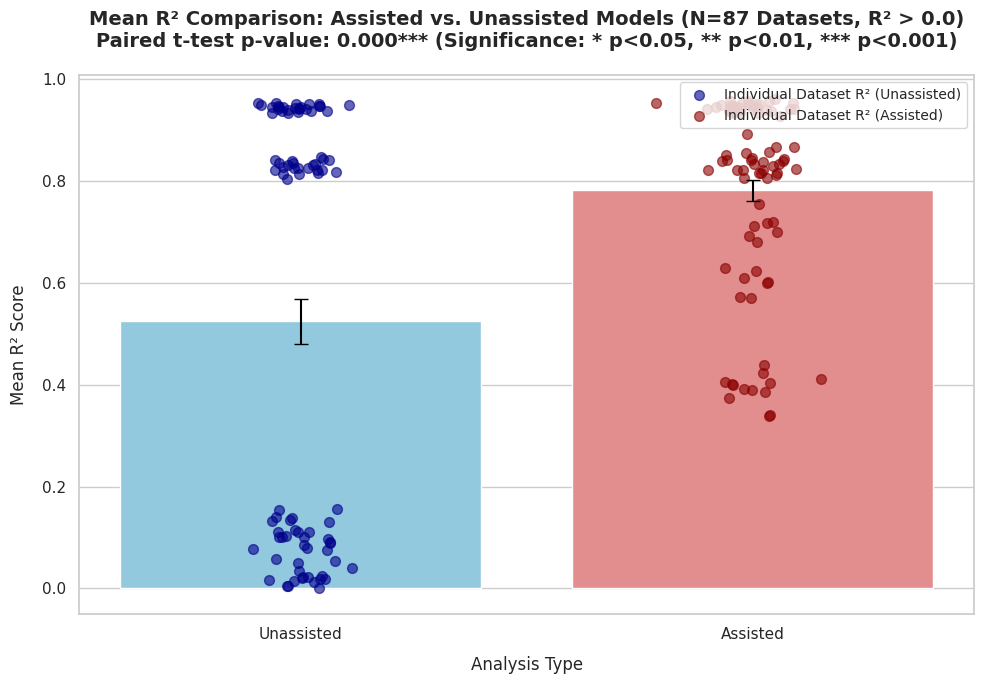


--- SVI vs. R2 Difference Analysis ---
SVI vs. R2 difference plot saved to analysis_figures/svi_vs_r2_difference_r2gt0.0.png


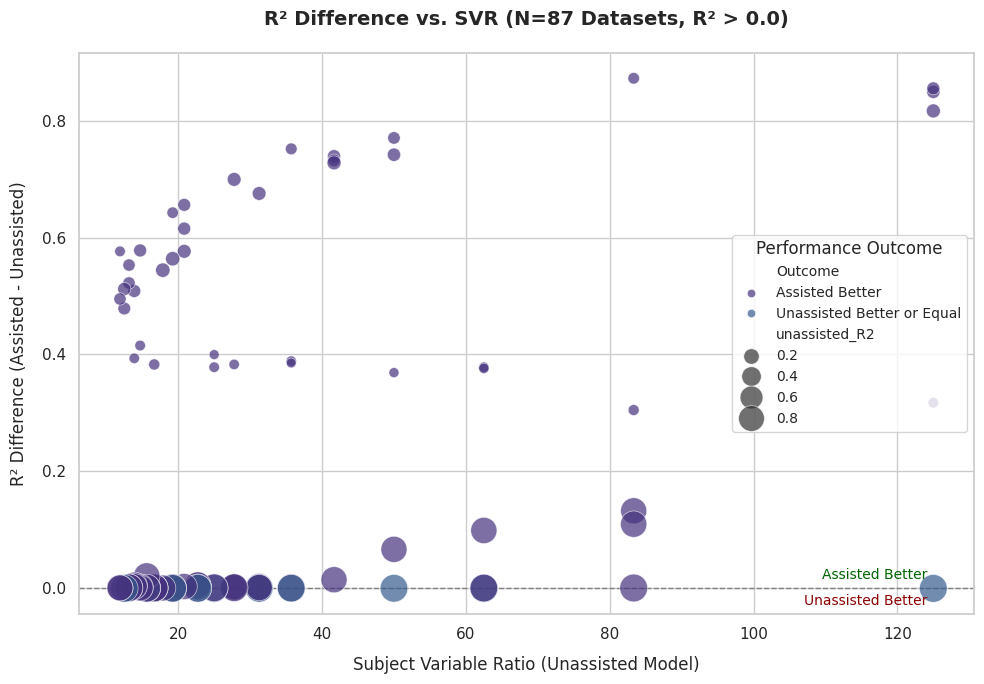


All analyses and plots complete. Check the 'analysis_figures' directory.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats # For statistical tests

# --- Configuration ---
# Assuming combined_regression_results.csv is in the same directory as this script
RESULTS_FILE = "combined_regression_results.csv"
FIGURES_DIR = "analysis_figures" # Directory for plots

# Ensure the figures directory exists
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)
    print(f"Created directory: {FIGURES_DIR}")

# --- Helper Functions ---

def load_and_prepare_data(file_path):
    """
    Loads the results CSV, cleans it, and prepares for analysis.
    """
    if not os.path.exists(file_path):
        print(f"Error: Results file not found at {file_path}.")
        print("Please ensure 'combined_regression_results.csv' is in the same directory as this script.")
        return None

    df = pd.read_csv(file_path)

    # Ensure numeric types and handle NaNs
    df['Mean_R2'] = pd.to_numeric(df['Mean_R2'], errors='coerce')
    df['R2_StdDev'] = pd.to_numeric(df['R2_StdDev'], errors='coerce')
    df['SVI'] = pd.to_numeric(df['SVI'], errors='coerce')

    # Drop rows where essential metrics are NaN (e.g., if a model failed completely)
    df.dropna(subset=['Mean_R2', 'SVI'], inplace=True)

    print(f"Loaded data from: {file_path}")
    print(f"Total rows after initial NaN drop for Mean_R2/SVI: {len(df)}")
    return df

def get_paired_data(df):
    """
    Creates a paired DataFrame for Assisted vs. Unassisted comparison.
    For Assisted, it selects the best performing LLM cluster for each dataset.
    """
    # Filter for unassisted results
    unassisted_df = df[df['AnalysisType'] == 'Unassisted'].copy()
    
    # In the combined_regression_results, 'Mean_R2' is already the best model's R2 for 'Unassisted'
    # So we just need to select unique Dataset-Mean_R2 pairs.
    unassisted_paired = unassisted_df.groupby('Dataset').agg(
        unassisted_R2=('Mean_R2', 'first'), # Take the first R2 for the unassisted dataset
        unassisted_R2_std=('R2_StdDev', 'first'),
        unassisted_SVI=('SVI', 'first')
    ).reset_index()

    # For assisted, find the best performing LLM cluster for each dataset
    assisted_df = df[df['AnalysisType'] == 'Assisted'].copy()
    
    # Group by Dataset and find the row with the maximum Mean_R2 (best assisted model for that dataset)
    # Use idxmax() to get the index of the max R2 within each group
    best_assisted_per_dataset_idx = assisted_df.groupby('Dataset')['Mean_R2'].idxmax()
    best_assisted_per_dataset = assisted_df.loc[best_assisted_per_dataset_idx]
    
    # Select relevant columns and rename for merging
    best_assisted_paired = best_assisted_per_dataset[[
        'Dataset', 'Mean_R2', 'R2_StdDev', 'SVI', 'LLM_Cluster_Used'
    ]].rename(columns={
        'Mean_R2': 'assisted_R2',
        'R2_StdDev': 'assisted_R2_std',
        'SVI': 'assisted_SVI',
        'LLM_Cluster_Used': 'best_LLM_cluster'
    })

    # Merge to get paired data
    paired_df = pd.merge(
        unassisted_paired,
        best_assisted_paired,
        on='Dataset',
        how='inner' # Only include datasets that have both unassisted and assisted results
    )
    
    # Calculate the difference
    paired_df['R2_diff'] = paired_df['assisted_R2'] - paired_df['unassisted_R2']
    
    print(f"\nPaired data created. Initial paired datasets: {len(paired_df)}")
    return paired_df

def analyze_and_plot_paired_r2(paired_df, r2_threshold=0.0):
    """
    Performs paired analysis, describes row counts, and generates the comparison plot.
    """
    print("\n--- Paired Analysis: Assisted vs. Unassisted R-squared ---")

    # 1. Describe row counts before and after filtering
    initial_unassisted_rows = paired_df['Dataset'].nunique() # Each row in paired_df is a unique dataset
    initial_assisted_rows = paired_df['Dataset'].nunique() # Same for assisted, as it's paired
    
    print(f"Initial rows for paired analysis (before R2 threshold):")
    print(f"  Unassisted: {initial_unassisted_rows} datasets")
    print(f"  Assisted (best per dataset): {initial_assisted_rows} datasets")

    # Filter for valid R-squared (good models)
    valid_paired_df = paired_df[
        (paired_df['unassisted_R2'] > r2_threshold) &
        (paired_df['assisted_R2'] > r2_threshold)
    ].copy()

    filtered_unassisted_rows = valid_paired_df['Dataset'].nunique()
    filtered_assisted_rows = valid_paired_df['Dataset'].nunique()

    print(f"\nRows after filtering for R2 > {r2_threshold}:")
    print(f"  Unassisted: {filtered_unassisted_rows} datasets")
    print(f"  Assisted (best per dataset): {filtered_assisted_rows} datasets")

    if valid_paired_df.empty:
        print("No valid datasets remaining after R2 thresholding for paired analysis. Skipping plot and t-test.")
        return

    # 2. Generate p-value (paired t-test)
    t_stat, p_value = stats.ttest_rel(valid_paired_df['assisted_R2'], valid_paired_df['unassisted_R2'])

    print(f"\nPaired t-test (Assisted R2 vs. Unassisted R2) for R2 > {r2_threshold}:")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f}")

    # Determine significance stars for plot
    sig_stars = ""
    if p_value < 0.001:
        sig_stars = "***"
    elif p_value < 0.01:
        sig_stars = "**"
    elif p_value < 0.05:
        sig_stars = "*"

    # 3. Visualization: Bar plot with scatter overlay and Mean/SEM
    sns.set_theme(style="whitegrid", palette="pastel") # Consistent color scheme
    plt.figure(figsize=(10, 7)) # Good figure size for publication

    # Prepare data for plotting means and SEM
    plot_data = pd.DataFrame({
        'Type': ['Unassisted', 'Assisted'],
        'Mean_R2': [valid_paired_df['unassisted_R2'].mean(), valid_paired_df['assisted_R2'].mean()],
        'SEM_R2': [
            valid_paired_df['unassisted_R2'].sem(), # Standard Error of the Mean
            valid_paired_df['assisted_R2'].sem()
        ]
    })

    # Bar plot for means
    bar_plot = sns.barplot(
        data=plot_data,
        x='Type',
        y='Mean_R2',
        hue='Type', # Explicitly map hue to 'Type' to avoid FutureWarnings and ensure legend
        palette=['skyblue', 'lightcoral'], # Custom colors for clarity
        errorbar=None, # We'll add error bars manually as SEM
        legend=False, # Hide the redundant legend as we'll create a custom one
        zorder=1
    )

    # Overlaid scatter plot for individual data points
    # Jitter the x-axis for better visibility of points
    x_jitter_unassisted = np.random.normal(bar_plot.patches[0].get_x() + bar_plot.patches[0].get_width() / 2, 0.05, len(valid_paired_df))
    x_jitter_assisted = np.random.normal(bar_plot.patches[1].get_x() + bar_plot.patches[1].get_width() / 2, 0.05, len(valid_paired_df))

    plt.scatter(x_jitter_unassisted, valid_paired_df['unassisted_R2'], color='darkblue', alpha=0.6, s=50, zorder=2, label='Individual Dataset R² (Unassisted)')
    plt.scatter(x_jitter_assisted, valid_paired_df['assisted_R2'], color='darkred', alpha=0.6, s=50, zorder=2, label='Individual Dataset R² (Assisted)')

    # Overlaid error bars for Mean +/- SEM
    plt.errorbar(
        x=plot_data['Type'],
        y=plot_data['Mean_R2'],
        yerr=plot_data['SEM_R2'],
        fmt='none', # No line connecting mean points
        capsize=5, # Size of the error bar caps
        color='black', # Color of error bars
        linewidth=1.5, # Width of error bar lines
        zorder=3
    )

    # --- Labels and Title ---
    plt.xlabel(f"Analysis Type", fontsize=12, labelpad=10) # Clear labels, padding
    plt.ylabel("Mean R² Score", fontsize=12, labelpad=10)
    
    # Title includes N datasets and p-value with significance stars explanation
    title_text = f"Mean R² Comparison: Assisted vs. Unassisted Models (N={len(valid_paired_df)} Datasets, R² > {r2_threshold})"
    title_text += f"\nPaired t-test p-value: {p_value:.3f}{sig_stars}"
    if sig_stars:
        title_text += f" (Significance: * p<0.05, ** p<0.01, *** p<0.001)"
    
    plt.title(title_text, fontsize=14, fontweight='bold', pad=20) # Bold title, padding

    plt.ylim(bottom=min(0, valid_paired_df['unassisted_R2'].min(), valid_paired_df['assisted_R2'].min()) - 0.05) # Adjust y-axis limit
    plt.legend(loc='upper right', fontsize=10) # Clear legend
    plt.tight_layout() # Ensures all elements fit without cropping

    # Save the figure with high DPI
    fig_path = os.path.join(FIGURES_DIR, f"assisted_vs_unassisted_r2_comparison_p{p_value:.3f}.png")
    plt.savefig(fig_path, dpi=600, format='png') # High resolution PNG
    print(f"Comparison plot saved to {fig_path}")
    plt.show() # <--- Added this line to display the plot
    plt.close()

def plot_svi_vs_r2_difference(paired_df, r2_threshold=0.0):
    """
    Explores the relationship between SVI and R2 difference (Assisted - Unassisted).
    """
    print("\n--- SVI vs. R2 Difference Analysis ---")

    # Filter for valid R-squared (good models)
    valid_paired_df = paired_df[
        (paired_df['unassisted_R2'] > r2_threshold) &
        (paired_df['assisted_R2'] > r2_threshold)
    ].copy()

    if valid_paired_df.empty:
        print("No valid datasets remaining after R2 thresholding for SVI analysis. Skipping plot.")
        return

    # Determine which analysis type is better for each dataset
    valid_paired_df['Outcome'] = np.where(valid_paired_df['R2_diff'] > 0, 'Assisted Better', 'Unassisted Better or Equal')

    sns.set_theme(style="whitegrid", palette="viridis") # Consistent color scheme
    plt.figure(figsize=(10, 7)) # Good figure size for publication

    scatter_plot = sns.scatterplot(
        data=valid_paired_df,
        x='unassisted_SVI', # Using unassisted_SVI as the base SVI for the dataset
        y='R2_diff',
        hue='Outcome',
        size='unassisted_R2', # Size points by unassisted R2 to give context
        sizes=(50, 400), # Range of marker sizes
        alpha=0.7,
        edgecolor='w', # White edge for points
        linewidth=0.5,
        zorder=2
    )

    # Add a horizontal line at R2_diff = 0
    plt.axhline(0, color='gray', linestyle='--', linewidth=1, zorder=1)

    # Annotate the line
    # Position text relative to plot limits for robustness
    xlim = plt.xlim()
    ylim = plt.ylim()
    plt.text(xlim[1] * 0.95, 0.01, 'Assisted Better', va='bottom', ha='right', color='darkgreen', fontsize=10)
    plt.text(xlim[1] * 0.95, -0.01, 'Unassisted Better', va='top', ha='right', color='darkred', fontsize=10)


    plt.xlabel("Subject Variable Ratio (Unassisted Model)", fontsize=12, labelpad=10) # Clear labels, padding
    plt.ylabel("R² Difference (Assisted - Unassisted)", fontsize=12, labelpad=10)
    plt.title(f"R² Difference vs. SVR (N={len(valid_paired_df)} Datasets, R² > {r2_threshold})", fontsize=14, fontweight='bold', pad=20) # Bold title, padding
    
    plt.legend(title="Performance Outcome", loc='best', fontsize=10) # Clear legend
    plt.tight_layout() # Ensures all elements fit without cropping

    # Save the figure with high DPI
    fig_path = os.path.join(FIGURES_DIR, f"svi_vs_r2_difference_r2gt{r2_threshold}.png")
    plt.savefig(fig_path, dpi=600, format='png') # High resolution PNG
    print(f"SVI vs. R2 difference plot saved to {fig_path}")
    plt.show() # <--- Added this line to display the plot
    plt.close()


# --- Main Execution ---
def main():
    df_combined = load_and_prepare_data(RESULTS_FILE)
    if df_combined is None:
        return

    # Get paired data for comparison
    paired_df = get_paired_data(df_combined)
    if paired_df.empty:
        print("No paired datasets found for analysis. Exiting.")
        return

    # Analyze and plot paired R2 comparison
    # You can adjust the r2_threshold here. For example, r2_threshold=0.0 means R2 must be positive.
    analyze_and_plot_paired_r2(paired_df, r2_threshold=0.0)

    # Explore SVI relationship
    plot_svi_vs_r2_difference(paired_df, r2_threshold=0.0)

    print("\nAll analyses and plots complete. Check the 'analysis_figures' directory.")

if __name__ == "__main__":
    main()


## Exploring grouping in SVR

Loaded data from: combined_regression_results.csv
Total rows after initial NaN drop for Mean_R2/SVI: 2451

Paired data created. Initial paired datasets: 100

--- Paired Analysis: Assisted vs. Unassisted R-squared ---
Initial rows for paired analysis (before R2 threshold):
  Unassisted: 100 datasets
  Assisted (best per dataset): 100 datasets

Rows after filtering for R2 > 0.0:
  Unassisted: 87 datasets
  Assisted (best per dataset): 87 datasets

Paired t-test (Assisted R2 vs. Unassisted R2) for R2 > 0.0:
  t-statistic: 8.046
  p-value: 0.0000
Comparison plot saved to analysis_figures/assisted_vs_unassisted_r2_comparison_p0.000.png


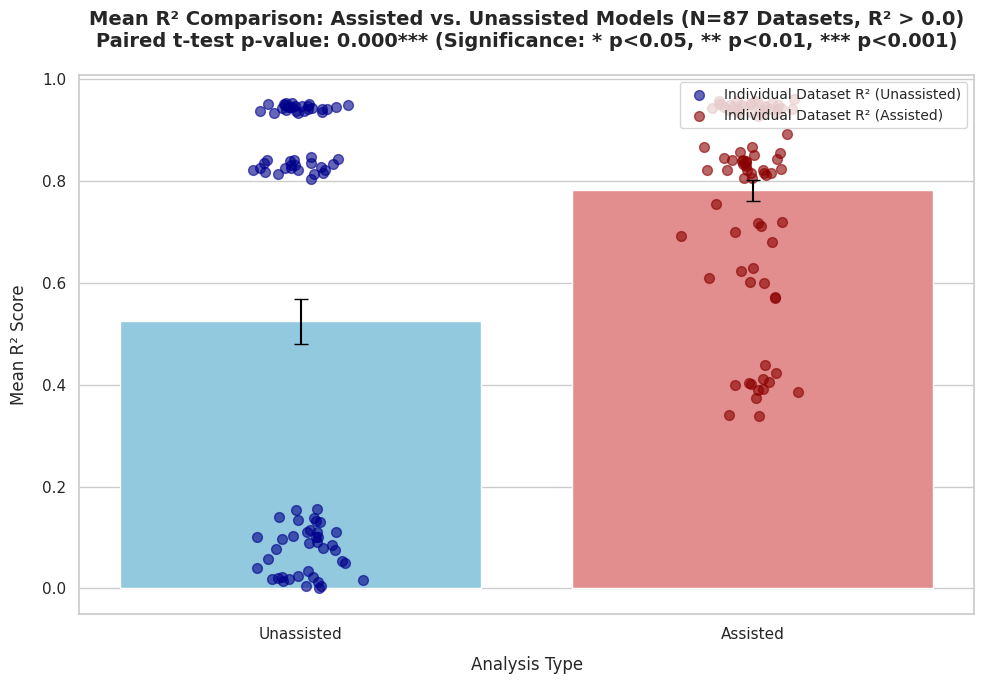


--- SVI vs. R2 Difference Analysis with Enhanced Grouping and Regression Lines ---

--- Datasets in Each Performance Group ---

'Similar Performance' Group (N=42 datasets):
           Dataset   R2_diff  unassisted_SVI
1   data_10_linear -0.000271       62.500000
5   data_14_linear  0.000192       62.500000
10  data_19_linear -0.000222       50.000000
20  data_28_linear  0.000232       35.714286
21  data_29_linear -0.000029       35.714286

'Assisted Better' Group (N=21 datasets):
               Dataset   R2_diff  unassisted_SVI
0   data_0_exponential  0.317376           125.0
2  data_11_exponential  0.378258            62.5
3  data_12_exponential  0.376174            62.5
4        data_13_cubic  0.098743            62.5
7        data_16_cubic  0.066437            50.0

'Assisted Significantly Better' Group (N=24 datasets):
              Dataset   R2_diff  unassisted_SVI
6   data_15_quadratic  0.770557       50.000000
9   data_18_quadratic  0.741868       50.000000
11   data_1_quadrati

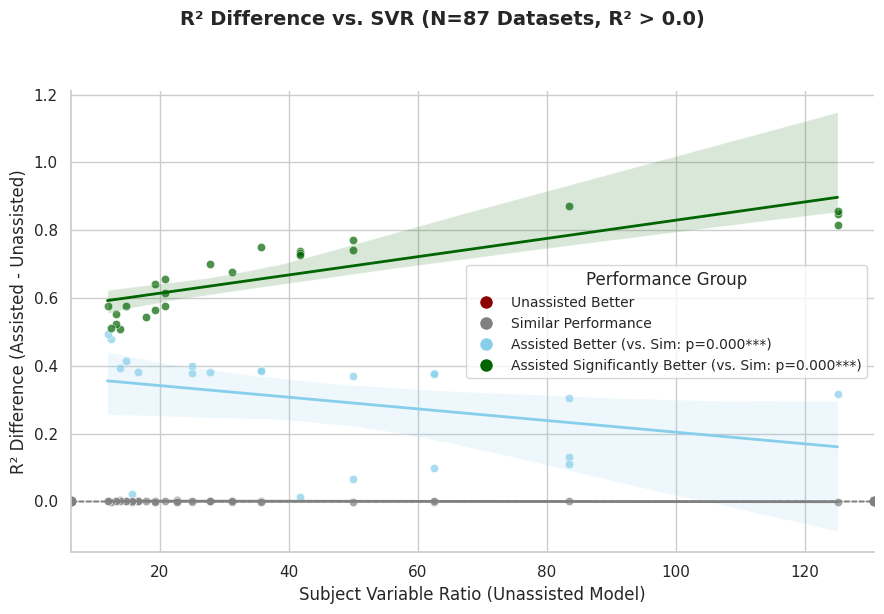


All analyses and plots complete. Check the 'analysis_figures' directory.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats # For statistical tests
from matplotlib.lines import Line2D # For creating custom legend handles

# --- Configuration ---
# Assuming combined_regression_results.csv is in the same directory as this script
RESULTS_FILE = "combined_regression_results.csv"
FIGURES_DIR = "analysis_figures" # Directory for plots

# Ensure the figures directory exists
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)
    print(f"Created directory: {FIGURES_DIR}")

# --- Helper Functions ---

def load_and_prepare_data(file_path):
    """
    Loads the results CSV, cleans it, and prepares for analysis.
    """
    if not os.path.exists(file_path):
        print(f"Error: Results file not found at {file_path}.")
        print("Please ensure 'combined_regression_results.csv' is in the same directory as this script.")
        return None

    df = pd.read_csv(file_path)

    # Ensure numeric types and handle NaNs
    df['Mean_R2'] = pd.to_numeric(df['Mean_R2'], errors='coerce')
    df['R2_StdDev'] = pd.to_numeric(df['R2_StdDev'], errors='coerce')
    df['SVI'] = pd.to_numeric(df['SVI'], errors='coerce')

    # Drop rows where essential metrics are NaN (e.g., if a model failed completely)
    df.dropna(subset=['Mean_R2', 'SVI'], inplace=True)

    print(f"Loaded data from: {file_path}")
    print(f"Total rows after initial NaN drop for Mean_R2/SVI: {len(df)}")
    return df

def get_paired_data(df):
    """
    Creates a paired DataFrame for Assisted vs. Unassisted comparison.
    For Assisted, it selects the best performing LLM cluster for each dataset.
    """
    # Filter for unassisted results
    unassisted_df = df[df['AnalysisType'] == 'Unassisted'].copy()
    
    # In the combined_regression_results, 'Mean_R2' is already the best model's R2 for 'Unassisted'
    # So we just need to select unique Dataset-Mean_R2 pairs.
    unassisted_paired = unassisted_df.groupby('Dataset').agg(
        unassisted_R2=('Mean_R2', 'first'), # Take the first R2 for the unassisted dataset
        unassisted_R2_std=('R2_StdDev', 'first'),
        unassisted_SVI=('SVI', 'first')
    ).reset_index()

    # For assisted, find the best performing LLM cluster for each dataset
    assisted_df = df[df['AnalysisType'] == 'Assisted'].copy()
    
    # Group by Dataset and find the row with the maximum Mean_R2 (best assisted model for that dataset)
    # Use idxmax() to get the index of the max R2 within each group
    best_assisted_per_dataset_idx = assisted_df.groupby('Dataset')['Mean_R2'].idxmax()
    best_assisted_per_dataset = assisted_df.loc[best_assisted_per_dataset_idx]
    
    # Select relevant columns and rename for merging
    best_assisted_paired = best_assisted_per_dataset[[
        'Dataset', 'Mean_R2', 'R2_StdDev', 'SVI', 'LLM_Cluster_Used'
    ]].rename(columns={
        'Mean_R2': 'assisted_R2',
        'R2_StdDev': 'assisted_R2_std',
        'SVI': 'assisted_SVI',
        'LLM_Cluster_Used': 'best_LLM_cluster'
    })

    # Merge to get paired data
    paired_df = pd.merge(
        unassisted_paired,
        best_assisted_paired,
        on='Dataset',
        how='inner' # Only include datasets that have both unassisted and assisted results
    )
    
    # Calculate the difference
    paired_df['R2_diff'] = paired_df['assisted_R2'] - paired_df['unassisted_R2']
    
    print(f"\nPaired data created. Initial paired datasets: {len(paired_df)}")
    return paired_df

def analyze_and_plot_paired_r2(paired_df, r2_threshold=0.0):
    """
    Performs paired analysis, describes row counts, and generates the comparison plot.
    """
    print("\n--- Paired Analysis: Assisted vs. Unassisted R-squared ---")

    # 1. Describe row counts before and after filtering
    initial_unassisted_rows = paired_df['Dataset'].nunique() # Each row in paired_df is a unique dataset
    initial_assisted_rows = paired_df['Dataset'].nunique() # Same for assisted, as it's paired
    
    print(f"Initial rows for paired analysis (before R2 threshold):")
    print(f"  Unassisted: {initial_unassisted_rows} datasets")
    print(f"  Assisted (best per dataset): {initial_assisted_rows} datasets")

    # Filter for valid R-squared (good models)
    valid_paired_df = paired_df[
        (paired_df['unassisted_R2'] > r2_threshold) &
        (paired_df['assisted_R2'] > r2_threshold)
    ].copy()

    filtered_unassisted_rows = valid_paired_df['Dataset'].nunique()
    filtered_assisted_rows = valid_paired_df['Dataset'].nunique()

    print(f"\nRows after filtering for R2 > {r2_threshold}:")
    print(f"  Unassisted: {filtered_unassisted_rows} datasets")
    print(f"  Assisted (best per dataset): {filtered_assisted_rows} datasets")

    if valid_paired_df.empty:
        print("No valid datasets remaining after R2 thresholding for paired analysis. Skipping plot and t-test.")
        return

    # 2. Generate p-value (paired t-test)
    t_stat, p_value = stats.ttest_rel(valid_paired_df['assisted_R2'], valid_paired_df['unassisted_R2'])

    print(f"\nPaired t-test (Assisted R2 vs. Unassisted R2) for R2 > {r2_threshold}:")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f}")

    # Determine significance stars for plot
    sig_stars = ""
    if p_value < 0.001:
        sig_stars = "***"
    elif p_value < 0.01:
        sig_stars = "**"
    elif p_value < 0.05:
        sig_stars = "*"

    # 3. Visualization: Bar plot with scatter overlay and Mean/SEM
    sns.set_theme(style="whitegrid", palette="pastel") # Consistent color scheme
    plt.figure(figsize=(10, 7)) # Good figure size for publication

    # Prepare data for plotting means and SEM
    plot_data = pd.DataFrame({
        'Type': ['Unassisted', 'Assisted'],
        'Mean_R2': [valid_paired_df['unassisted_R2'].mean(), valid_paired_df['assisted_R2'].mean()],
        'SEM_R2': [
            valid_paired_df['unassisted_R2'].sem(), # Standard Error of the Mean
            valid_paired_df['assisted_R2'].sem()
        ]
    })

    # Bar plot for means
    bar_plot = sns.barplot(
        data=plot_data,
        x='Type',
        y='Mean_R2',
        hue='Type', # Explicitly map hue to 'Type' to avoid FutureWarnings and ensure legend
        palette=['skyblue', 'lightcoral'], # Custom colors for clarity
        errorbar=None, # We'll add error bars manually as SEM
        legend=False, # Hide the redundant legend as we'll create a custom one
        zorder=1
    )

    # Overlaid scatter plot for individual data points
    # Jitter the x-axis for better visibility of points
    x_jitter_unassisted = np.random.normal(bar_plot.patches[0].get_x() + bar_plot.patches[0].get_width() / 2, 0.05, len(valid_paired_df))
    x_jitter_assisted = np.random.normal(bar_plot.patches[1].get_x() + bar_plot.patches[1].get_width() / 2, 0.05, len(valid_paired_df))

    plt.scatter(x_jitter_unassisted, valid_paired_df['unassisted_R2'], color='darkblue', alpha=0.6, s=50, zorder=2, label='Individual Dataset R² (Unassisted)')
    plt.scatter(x_jitter_assisted, valid_paired_df['assisted_R2'], color='darkred', alpha=0.6, s=50, zorder=2, label='Individual Dataset R² (Assisted)')

    # Overlaid error bars for Mean +/- SEM
    plt.errorbar(
        x=plot_data['Type'],
        y=plot_data['Mean_R2'],
        yerr=plot_data['SEM_R2'],
        fmt='none', # No line connecting mean points
        capsize=5, # Size of the error bar caps
        color='black', # Color of error bars
        linewidth=1.5, # Width of error bar lines
        zorder=3
    )

    # --- Labels and Title ---
    plt.xlabel(f"Analysis Type", fontsize=12, labelpad=10) # Clear labels, padding
    plt.ylabel("Mean R² Score", fontsize=12, labelpad=10)
    
    # Title includes N datasets and p-value with significance stars explanation
    title_text = f"Mean R² Comparison: Assisted vs. Unassisted Models (N={len(valid_paired_df)} Datasets, R² > {r2_threshold})"
    title_text += f"\nPaired t-test p-value: {p_value:.3f}{sig_stars}"
    if sig_stars:
        title_text += f" (Significance: * p<0.05, ** p<0.01, *** p<0.001)"
    
    plt.title(title_text, fontsize=14, fontweight='bold', pad=20) # Bold title, padding

    plt.ylim(bottom=min(0, valid_paired_df['unassisted_R2'].min(), valid_paired_df['assisted_R2'].min()) - 0.05) # Adjust y-axis limit
    plt.legend(loc='upper right', fontsize=10) # Clear legend
    plt.tight_layout() # Ensures all elements fit without cropping

    # Save the figure with high DPI
    fig_path = os.path.join(FIGURES_DIR, f"assisted_vs_unassisted_r2_comparison_p{p_value:.3f}.png")
    plt.savefig(fig_path, dpi=600, format='png') # High resolution PNG
    print(f"Comparison plot saved to {fig_path}")
    plt.show() # <--- Added this line to display the plot
    plt.close()

def plot_svi_vs_r2_difference(paired_df, r2_threshold=0.0):
    """
    Explores the relationship between SVI and R2 difference (Assisted - Unassisted)
    and fits regression lines to different performance groups, showing p-values in legend.
    """
    print("\n--- SVI vs. R2 Difference Analysis with Enhanced Grouping and Regression Lines ---")

    # Filter for valid R-squared (good models)
    valid_paired_df = paired_df[
        (paired_df['unassisted_R2'] > r2_threshold) &
        (paired_df['assisted_R2'] > r2_threshold)
    ].copy()

    if valid_paired_df.empty:
        print("No valid datasets remaining after R2 thresholding for SVI analysis. Skipping plot.")
        return

    # Define thresholds for grouping
    epsilon = 0.01  # For "Similar Performance" around zero R2_diff
    significant_improvement_threshold = 0.5 # User-defined threshold

    # Determine which analysis type is better for each dataset and assign to groups
    def assign_group(row):
        if row['R2_diff'] > significant_improvement_threshold:
            return 'Assisted Significantly Better'
        elif row['R2_diff'] > epsilon:
            return 'Assisted Better'
        elif row['R2_diff'] < -epsilon:
            return 'Unassisted Better'
        else:
            return 'Similar Performance'

    valid_paired_df['Performance_Group'] = valid_paired_df.apply(assign_group, axis=1)

    # --- Print Dataframes for each group ---
    print("\n--- Datasets in Each Performance Group ---")
    
    # Group 1: Similar Performance
    similar_df = valid_paired_df[valid_paired_df['Performance_Group'] == 'Similar Performance']
    print(f"\n'Similar Performance' Group (N={len(similar_df)} datasets):")
    if not similar_df.empty:
        print(similar_df[['Dataset', 'R2_diff', 'unassisted_SVI']].head()) # Show relevant columns
    else:
        print("  (No datasets in this group)")

    # Group 2: Assisted Better
    assisted_better_df = valid_paired_df[valid_paired_df['Performance_Group'] == 'Assisted Better']
    print(f"\n'Assisted Better' Group (N={len(assisted_better_df)} datasets):")
    if not assisted_better_df.empty:
        print(assisted_better_df[['Dataset', 'R2_diff', 'unassisted_SVI']].head()) # Show relevant columns
    else:
        print("  (No datasets in this group)")

    # Group 3: Assisted Significantly Better
    assisted_sig_better_df = valid_paired_df[valid_paired_df['Performance_Group'] == 'Assisted Significantly Better']
    print(f"\n'Assisted Significantly Better' Group (N={len(assisted_sig_better_df)} datasets):")
    if not assisted_sig_better_df.empty:
        print(assisted_sig_better_df[['Dataset', 'R2_diff', 'unassisted_SVI']].head()) # Show relevant columns
    else:
        print("  (No datasets in this group)")

    # Group 4: Unassisted Better (if any)
    unassisted_better_df = valid_paired_df[valid_paired_df['Performance_Group'] == 'Unassisted Better']
    print(f"\n'Unassisted Better' Group (N={len(unassisted_better_df)} datasets):")
    if not unassisted_better_df.empty:
        print(unassisted_better_df[['Dataset', 'R2_diff', 'unassisted_SVI']].head()) # Show relevant columns
    else:
        print("  (No datasets in this group)")
    
    print("------------------------------------------------------------")
    # --- End of Dataframe Printing ---

    # --- Value Counts for Dataset Types within each group (as a DataFrame) ---
    print("\n--- Dataset Type Counts within Performance Groups (Tabular) ---")

    dataset_types = ['exponential', 'cubic', 'quadratic', 'linear']

    # Function to count types in a DataFrame and return as a Series
    def count_dataset_types_series(df_group):
        type_counts = {dtype: 0 for dtype in dataset_types}
        if df_group.empty:
            return pd.Series(type_counts) # Return all zeros if group is empty

        for _, row in df_group.iterrows():
            dataset_name = row['Dataset'].lower()
            found = False
            for dtype in dataset_types:
                if dtype in dataset_name:
                    type_counts[dtype] += 1
                    found = True
                    break
            # No warning print here, as it's for a structured output
        return pd.Series(type_counts)

    # Create a dictionary to hold the Series for each group
    group_counts = {}
    group_counts['Similar Performance'] = count_dataset_types_series(similar_df)
    group_counts['Assisted Better'] = count_dataset_types_series(assisted_better_df)
    group_counts['Assisted Significantly Better'] = count_dataset_types_series(assisted_sig_better_df)
    group_counts['Unassisted Better'] = count_dataset_types_series(unassisted_better_df)

    # Create a DataFrame from the dictionary of Series
    df_type_counts = pd.DataFrame(group_counts).T # Transpose to have groups as rows and types as columns
    df_type_counts.index.name = 'Performance Group'
    df_type_counts.columns = [col.capitalize() for col in df_type_counts.columns] # Capitalize column names

    print(df_type_counts)

    # --- Perform Chi-squared test on the dataset type counts table ---
    # Ensure there are enough observations and no zero rows/columns for the test
    if not df_type_counts.empty and (df_type_counts.sum(axis=1) > 0).all() and (df_type_counts.sum(axis=0) > 0).all():
        chi2, p_value_chi2, dof, expected = stats.chi2_contingency(df_type_counts)
        print(f"\nChi-squared test for association between Performance Group and Dataset Type:")
        print(f"  Chi-squared statistic: {chi2:.3f}")
        print(f"  p-value: {p_value_chi2:.4f}")
        print(f"  Degrees of freedom: {dof}")
    else:
        print("\nSkipping Chi-squared test: Contingency table is empty or contains all zero rows/columns.")
    
    print("------------------------------------------------------------")
    # --- End of Value Counts ---


    # --- Perform one-sample t-tests for each group (vs. 0) ---
    print("\n--- Statistical Tests for Performance Groups (One-Sample t-test vs. 0) ---")

    # Group 1: Similar Performance
    p_value_similar = None
    if not similar_df.empty:
        t_stat_similar, p_value_similar = stats.ttest_1samp(similar_df['R2_diff'], 0)
        print(f"Similar Performance (N={len(similar_df)}):")
        print(f"  Mean R2_diff: {similar_df['R2_diff'].mean():.3f}")
        print(f"  One-sample t-test vs. 0: t={t_stat_similar:.3f}, p={p_value_similar:.4f}")
    else:
        print("No data for 'Similar Performance' group to test.")

    # Group 2: Assisted Better
    p_value_assisted_better = None
    if not assisted_better_df.empty:
        t_stat_assisted_better, p_value_assisted_better = stats.ttest_1samp(assisted_better_df['R2_diff'], 0)
        print(f"\nAssisted Better (N={len(assisted_better_df)}):")
        print(f"  Mean R2_diff: {assisted_better_df['R2_diff'].mean():.3f}")
        print(f"  One-sample t-test vs. 0: t={t_stat_assisted_better:.3f}, p={p_value_assisted_better:.4f}")
    else:
        print("No data for 'Assisted Better' group to test.")

    # Group 3: Assisted Significantly Better
    p_value_assisted_sig_better = None
    if not assisted_sig_better_df.empty:
        t_stat_assisted_sig_better, p_value_assisted_sig_better = stats.ttest_1samp(assisted_sig_better_df['R2_diff'], 0)
        print(f"\nAssisted Significantly Better (N={len(assisted_sig_better_df)}):")
        print(f"  Mean R2_diff: {assisted_sig_better_df['R2_diff'].mean():.3f}")
        print(f"  One-sample t-test vs. 0: t={t_stat_assisted_sig_better:.3f}, p={p_value_assisted_sig_better:.4f}")
    else:
        print("No data for 'Assisted Significantly Better' group to test.")

    print("------------------------------------------------------------")
    # --- End of One-Sample Statistical Tests ---

    # --- Perform Independent Samples t-tests (comparing to 'Similar Performance' baseline) ---
    print("\n--- Independent Samples t-tests (vs. 'Similar Performance' Baseline) ---")

    # Initialize p-values for comparisons
    p_value_ab_vs_sp = None
    p_value_asb_vs_sp = None

    if not similar_df.empty:
        # Compare 'Assisted Better' to 'Similar Performance'
        if not assisted_better_df.empty:
            t_stat_ab_vs_sp, p_value_ab_vs_sp = stats.ttest_ind(assisted_better_df['R2_diff'], similar_df['R2_diff'], equal_var=False) # Welch's t-test
            print(f"Assisted Better vs. Similar Performance (N_AB={len(assisted_better_df)}, N_SP={len(similar_df)}):")
            print(f"  t={t_stat_ab_vs_sp:.3f}, p={p_value_ab_vs_sp:.4f}")
        else:
            print("Cannot compare 'Assisted Better' to 'Similar Performance': 'Assisted Better' group is empty.")

        # Compare 'Assisted Significantly Better' to 'Similar Performance'
        if not assisted_sig_better_df.empty:
            t_stat_asb_vs_sp, p_value_asb_vs_sp = stats.ttest_ind(assisted_sig_better_df['R2_diff'], similar_df['R2_diff'], equal_var=False) # Welch's t-test
            print(f"\nAssisted Significantly Better vs. Similar Performance (N_ASB={len(assisted_sig_better_df)}, N_SP={len(similar_df)}):")
            print(f"  t={t_stat_asb_vs_sp:.3f}, p={p_value_asb_vs_sp:.4f}")
        else:
            print("Cannot compare 'Assisted Significantly Better' to 'Similar Performance': 'Assisted Significantly Better' group is empty.")
    else:
        print("Cannot perform baseline comparisons: 'Similar Performance' group is empty.")

    print("------------------------------------------------------------")
    # --- End of Independent Samples Statistical Tests ---


    sns.set_theme(style="whitegrid") # Consistent theme

    # Define a custom palette to ensure distinct colors for the new group
    custom_palette = {
        'Assisted Significantly Better': 'darkgreen',
        'Assisted Better': 'skyblue',
        'Unassisted Better': 'darkred',
        'Similar Performance': 'gray'
    }

    # Use lmplot for scatter plot with regression lines for each group
    # Set legend=False here, we will create a custom legend later
    lm = sns.lmplot(
        data=valid_paired_df,
        x='unassisted_SVI',
        y='R2_diff',
        hue='Performance_Group',
        height=6,
        aspect=1.5,
        scatter_kws={'alpha': 0.7, 'edgecolor': 'w', 'linewidths': 0.5},
        line_kws={'linewidth': 2},
        palette=custom_palette,
        ci=95,
        legend=False # Disable default legend
    )

    # Add a horizontal line at R2_diff = 0
    lm.refline(y=0, linestyle='--', color='gray', linewidth=1, zorder=1)

    # Set labels and title
    lm.set_axis_labels("Subject Variable Ratio (Unassisted Model)", "R² Difference (Assisted - Unassisted)")
    lm.set_titles("R² Difference vs. SVR with Grouped Regression Lines")
    plt.suptitle(f"R² Difference vs. SVR (N={len(valid_paired_df)} Datasets, R² > {r2_threshold})", 
                 fontsize=14, fontweight='bold', y=1.02) # Adjust y for suptitle

    # --- Custom Legend with P-values ---
    legend_handles = []
    legend_labels = []

    # Helper to get significance stars
    def get_sig_stars(p_val):
        if p_val is None:
            return ""
        if p_val < 0.001:
            return "***"
        elif p_val < 0.01:
            return "**"
        elif p_val < 0.05:
            return "*"
        else:
            return ""

    # Add legend entries for each group
    # Unassisted Better (no comparison p-value to show here, only its own mean relative to 0)
    legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette['Unassisted Better'], markersize=10, linestyle='-'))
    legend_labels.append(f"Unassisted Better")

    # Similar Performance (no comparison p-value to show here, only its own mean relative to 0)
    legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette['Similar Performance'], markersize=10, linestyle='-'))
    legend_labels.append(f"Similar Performance")

    # Assisted Better vs. Similar Performance
    label_ab = f"Assisted Better"
    if p_value_ab_vs_sp is not None:
        label_ab += f" (vs. Sim: p={p_value_ab_vs_sp:.3f}{get_sig_stars(p_value_ab_vs_sp)})"
    legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette['Assisted Better'], markersize=10, linestyle='-'))
    legend_labels.append(label_ab)

    # Assisted Significantly Better vs. Similar Performance
    label_asb = f"Assisted Significantly Better"
    if p_value_asb_vs_sp is not None:
        label_asb += f" (vs. Sim: p={p_value_asb_vs_sp:.3f}{get_sig_stars(p_value_asb_vs_sp)})"
    legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette['Assisted Significantly Better'], markersize=10, linestyle='-'))
    legend_labels.append(label_asb)

    # Add the legend to the plot
    plt.legend(handles=legend_handles, labels=legend_labels, title="Performance Group", loc='best', fontsize=10)
    # --- End Custom Legend ---
    
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap

    # Save the figure with high DPI
    fig_path = os.path.join(FIGURES_DIR, f"svi_vs_r2_difference_enhanced_grouped_regression_r2gt{r2_threshold}_with_pvalues.png")
    plt.savefig(fig_path, dpi=600, format='png') # High resolution PNG
    print(f"SVI vs. R2 difference plot with enhanced grouped regression lines and p-values saved to {fig_path}")
    plt.show() # <--- Added this line to display the plot
    plt.close()


# --- Main Execution ---
def main():
    df_combined = load_and_prepare_data(RESULTS_FILE)
    if df_combined is None:
        return

    # Get paired data for comparison
    paired_df = get_paired_data(df_combined)
    if paired_df.empty:
        print("No paired datasets found for analysis. Exiting.")
        return

    # Analyze and plot paired R2 comparison
    # You can adjust the r2_threshold here. For example, r2_threshold=0.0 means R2 must be positive.
    analyze_and_plot_paired_r2(paired_df, r2_threshold=0.0)

    # Explore SVI relationship with grouped regression lines
    plot_svi_vs_r2_difference(paired_df, r2_threshold=0.0)

    print("\nAll analyses and plots complete. Check the 'analysis_figures' directory.")

if __name__ == "__main__":
    main()


NameError: name 'similar_df' is not defined

## LLM unasssisted vs assisted analysis Logistic regression

I'm looking to transform your regression problem (x3 as a continuous outcome) into a binary classification problem. This involves converting x3 into a 0/1 variable based on its 75th percentile. You'll also need to switch from regression models and metrics (R², MAE) to classification models and metrics (AUC).

Here's the complete corrected code block:

Key Changes:

    Model Type Change: REG_MODELS is replaced with CLASS_MODELS containing LogisticRegression, RandomForestClassifier, and GradientBoostingClassifier.

    Metric Change: r2_score and mean_absolute_error are replaced with roc_auc_score.

    x3 Transformation: A new function binarize_x3_by_percentile is introduced to convert x3 into a binary (0/1) target based on the 75th percentile. This is applied per dataset to ensure the percentile is relevant to the data being analyzed.

    bootstrap_evaluate_classification_models: The evaluation function is adapted for classification, using AUC as the metric and handling SMOTE for imbalanced classes.

    SVI Calculation: The SVI calculation remains the same as it's based on the number of rows and features, not the target type.

    Output CSV Columns: The output CSV columns are updated to reflect AUC metrics (Mean_AUC, AUC_StdDev).

    Progress File: The progress file logic remains the same.

    Data Flow: x3 is now the target for both unassisted and assisted analyses. LLM clusters are features for the assisted analysis and excluded from the unassisted analysis.

In [43]:
import os
import numpy as np
import pandas as pd
from glob import glob
import csv
from collections import Counter

# sklearn
from sklearn.model_selection import train_test_split
# Changed metrics and models for classification
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's pipeline for SMOTE integration

# SHAP (kept for potential future use, not directly in main loop)
import shap

# -----------------------------------------------------
# CONFIG
# -----------------------------------------------------
# IMPORTANT: Adjust DATA_DIR to your actual path within WSL if running from WSL terminal
DATA_DIR = "/home/abbasali/synthetic data/generated_data_with_clusters"
# Output file will be in the directory where the script is run
# --- MODIFIED: Changed OUTPUT_FILE name to reflect logistic classification ---
OUTPUT_FILE = "combined_classification_logistic_results.csv"
PROGRESS_FILE = "classification_progress_logistic.csv" # Changed progress file name too
RANDOM_SEED = 42
N_BOOTSTRAP_SAMPLES = 100 # Number of bootstrap samples for evaluation

# Models for Classification
CLASS_MODELS = {
    "LogisticReg": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, solver='liblinear'), # Increased max_iter, added solver
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    "GradientBoost": GradientBoostingClassifier(random_state=RANDOM_SEED)
}

# --- Helper Functions ---

def build_preprocessor(numeric_cols, cat_cols):
    """
    Builds preprocessing pipelines:
      1. Numeric: median imputer + StandardScaler
      2. Categorical: most frequent imputer + OneHotEncoder
    """
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) # sparse_output=False for SVI calculation
    ])

    column_tf = ColumnTransformer([
        ("num", numeric_pipeline, numeric_cols),
        ("cat", cat_pipeline, cat_cols)
    ], remainder='passthrough')
    return column_tf

def get_transformed_feature_count(preprocessor, X, numeric_cols, cat_cols):
    """
    Estimates the number of features after transformation by fitting a dummy pipeline.
    This is needed for SVI calculation before actual model training.
    """
    if X.empty:
        return 0
    
    # Create a dummy DataFrame with one row to get feature count
    # Ensure dummy_X has the same columns as X and correct dtypes
    dummy_row_data = {}
    for col in X.columns:
        if col in numeric_cols:
            dummy_row_data[col] = [X[col].iloc[0] if not X[col].empty and pd.notna(X[col].iloc[0]) else 0.0]
        elif col in cat_cols:
            # For categorical, ensure at least one category exists or provide a default
            if not X[col].empty and pd.notna(X[col].iloc[0]):
                dummy_row_data[col] = [X[col].iloc[0]]
            elif not X[col].empty and X[col].dtype == 'category' and len(X[col].cat.categories) > 0:
                dummy_row_data[col] = [X[col].cat.categories[0]] # Use first category if available
            else:
                dummy_row_data[col] = ['dummy_cat'] # Fallback
        else: # For 'passthrough' columns
            dummy_row_data[col] = [X[col].iloc[0] if not X[col].empty and pd.notna(X[col].iloc[0]) else 0]

    if not dummy_row_data:
        return 0

    dummy_df = pd.DataFrame(dummy_row_data)
    
    # Ensure categorical columns are 'category' dtype in dummy_df
    for col in cat_cols:
        if col in dummy_df.columns:
            dummy_df[col] = dummy_df[col].astype('category')

    try:
        # Fit on the dummy DataFrame to get feature count
        transformed_sample = preprocessor.fit_transform(dummy_df)
        if hasattr(transformed_sample, 'shape'):
            return transformed_sample.shape[1]
        else:
            return len(transformed_sample)
    except Exception as e:
        print(f"Warning: Could not determine transformed feature count: {e}")
        return 0

def binarize_x3_by_percentile(df, column_name="x3", percentile=75):
    """
    Transforms a continuous variable into a binary (0/1) outcome
    based on a specified percentile.
    Values <= percentile become 0, values > percentile become 1.
    Handles NaNs by dropping them before calculation.
    """
    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found for binarization.")
        return None

    temp_series = df[column_name].dropna()
    if temp_series.empty:
        print(f"Warning: Column '{column_name}' is empty or all NaNs, cannot binarize.")
        return None
    
    threshold = np.percentile(temp_series, percentile)
    
    # Apply transformation to the original column, handling NaNs
    binarized_series = df[column_name].apply(lambda x: 1 if x > threshold else (0 if pd.notna(x) else np.nan))
    
    # Convert to integer type, NaNs will remain float unless filled
    return binarized_series.astype('Int64') # Use Int64 to allow NaNs in integer column

def compute_multi_class_auc(y_true, y_prob):
    """Ensures correct shape of probability predictions before computing AUC."""
    unique_y_true = np.unique(y_true)
    n_unique_y_true = len(unique_y_true)

    # Handle cases where y_prob might be 1D for binary classification
    if y_prob.ndim == 1:
        if n_unique_y_true != 2:
            print("      Warning: 1D y_prob received but y_true is not binary. Skipping AUC.")
            return None
        return roc_auc_score(y_true, y_prob)
    
    # For multi-class (y_prob is 2D)
    if y_prob.shape[1] != n_unique_y_true:
        print(f"      Warning: y_prob columns ({y_prob.shape[1]}) do not match unique y_true classes ({n_unique_y_true}). Skipping AUC.")
        return None
    
    # Binary classification (2 classes)
    if n_unique_y_true == 2:
        return roc_auc_score(y_true, y_prob[:, 1])
    # Multi-class classification (>2 classes) - though for this problem, it's binary
    else:
        return roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")


def bootstrap_evaluate_classification_models(X, y, numeric_cols, cat_cols, n_bootstrap_samples=N_BOOTSTRAP_SAMPLES):
    """
    Evaluates classification models using bootstrapping to get robust AUC estimates.
    Integrates preprocessing and SMOTE into an imblearn.pipeline.
    
    Returns a dictionary of mean AUCs and std dev AUCs for each model.
    """
    model_auc_scores = {name: [] for name in CLASS_MODELS.keys()}

    class_counts = Counter(y)
    min_class_count_overall = min(class_counts.values())
    
    smote_k_neighbors = min(5, min_class_count_overall - 1) if min_class_count_overall > 1 else None

    if len(np.unique(y)) < 2:
        print("      Single class in target (y) => skipping bootstrap evaluation.")
        return None, None

    for i in range(n_bootstrap_samples):
        np.random.seed(RANDOM_SEED + i) 
        
        bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
        X_bootstrap = X.iloc[bootstrap_indices].copy()
        y_bootstrap = y[bootstrap_indices].copy()

        stratify_option_bs = y_bootstrap if min(Counter(y_bootstrap).values()) >= 2 else None
        
        X_train_bs, X_test_bs, y_train_bs, y_test_bs = train_test_split(
            X_bootstrap, y_bootstrap, test_size=0.3, random_state=RANDOM_SEED + i, stratify=stratify_option_bs
        )

        if len(np.unique(y_train_bs)) < 2 or len(np.unique(y_test_bs)) < 2:
            continue

        preprocessor = build_preprocessor(numeric_cols, cat_cols)

        for model_name, model_obj in CLASS_MODELS.items(): # Use CLASS_MODELS
            if smote_k_neighbors is not None and smote_k_neighbors >= 1:
                full_pipeline = ImbPipeline([
                    ("preprocessor", preprocessor),
                    ("smote", SMOTE(random_state=RANDOM_SEED + i, k_neighbors=smote_k_neighbors)),
                    ("classifier", model_obj)
                ])
            else:
                full_pipeline = Pipeline([
                    ("preprocessor", preprocessor),
                    ("classifier", model_obj)
                ])

            try:
                full_pipeline.fit(X_train_bs, y_train_bs)
                y_prob_bs = full_pipeline.predict_proba(X_test_bs)
                
                auc_val = compute_multi_class_auc(y_test_bs, y_prob_bs)
                
                if auc_val is not None:
                    model_auc_scores[model_name].append(auc_val)
            except Exception as e:
                # print(f"      Bootstrap iteration {i+1}, Model {model_name}: Error during fit/predict: {e}")
                pass 

    mean_auc_scores = {name: np.mean(scores) if scores else np.nan for name, scores in model_auc_scores.items()}
    std_auc_scores = {name: np.std(scores) if scores else np.nan for name, scores in model_auc_scores.items()}
    
    return mean_auc_scores, std_auc_scores


def get_completed_datasets(progress_file):
    """Reads the progress file and returns a set of completed dataset names."""
    completed = set()
    if os.path.exists(progress_file):
        try:
            df_progress = pd.read_csv(progress_file)
            completed = set(df_progress['Dataset'].unique())
            print(f"Resuming: Found {len(completed)} completed datasets in {progress_file}.")
        except pd.errors.EmptyDataError:
            print(f"Progress file {progress_file} is empty, starting fresh.")
        except Exception as e:
            print(f"Error reading progress file {progress_file}: {e}. Starting fresh.")
    return completed

def append_results_to_csv(results_list, output_file):
    """Appends a list of dictionaries (results for one dataset) to a CSV."""
    if not results_list:
        return

    df_to_append = pd.DataFrame(results_list)
    if not os.path.exists(output_file):
        df_to_append.to_csv(output_file, index=False, mode='w')
    else:
        df_to_append.to_csv(output_file, index=False, mode='a', header=False)

def main():
    csv_files = glob(os.path.join(DATA_DIR, "*.csv"))
    if not csv_files:
        print(f"No CSV files found in {DATA_DIR}. Please check the DATA_DIR path.")
        return

    completed_datasets = get_completed_datasets(PROGRESS_FILE)

    for path in csv_files:
        ds_name = os.path.splitext(os.path.basename(path))[0]
        
        if ds_name in completed_datasets:
            print(f"\n--- Skipping already processed dataset: {ds_name} ---")
            continue

        print(f"\n--- Processing dataset: {ds_name} ---")
        df = pd.read_csv(path)

        # Convert x1, x2 to numeric
        for col in ["x1", "x2"]:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")
                df.dropna(subset=[col], inplace=True) # Drop rows with NaN in essential features

        # --- NEW: Process x3 for Classification ---
        if "x3" not in df.columns:
            print(f"    Skipping {ds_name}: no x3 found for target binarization.")
            continue
        
        # Binarize x3 based on 75th percentile
        df['x3_binary'] = binarize_x3_by_percentile(df, "x3", percentile=75)
        
        # Drop rows where the binarized x3 is NaN (if original x3 was NaN)
        df_cleaned = df.dropna(subset=["x3_binary"]).copy()
        if df_cleaned.empty:
            print(f"    Skipping {ds_name}: x3_binary all NaN after drop.")
            continue
        
        # Ensure the target is integer type (0 or 1)
        df_cleaned['x3_binary'] = df_cleaned['x3_binary'].astype(int)

        # Identify categorical columns (starting with 'cat')
        cat_cols_all = [c for c in df_cleaned.columns if c.startswith("cat")]
        for c in cat_cols_all:
            df_cleaned[c] = df_cleaned[c].astype("category")

        # Identify numeric features (x1, x2)
        numeric_cols_base = ["x1", "x2"]
        
        # Identify LLM cluster columns
        llm_cluster_cols = [c for c in df_cleaned.columns if c.startswith("cluster_")]
        
        current_dataset_results = [] # Collect results for this specific dataset

        # --- UNASSISTED ANALYSIS ---
        print(f"  Evaluating Unassisted Model for {ds_name}...")
        # Features for unassisted: numeric_cols_base + other 'cat' columns (excluding all cluster_ columns)
        unassisted_feature_cols = [col for col in df_cleaned.columns if col in numeric_cols_base or (col.startswith('cat') and col not in llm_cluster_cols)]
        
        X_unassisted = df_cleaned[unassisted_feature_cols].copy()
        y_unassisted = df_cleaned["x3_binary"].values # Use the binarized x3 as target

        # Check for sufficient data
        # For classification, need at least 2 unique classes (0 and 1) and min samples
        if len(X_unassisted) < 10 or len(np.unique(y_unassisted)) < 2:
            print(f"    Skipping Unassisted for {ds_name}: Not enough data or unique classes (0/1) after filtering.")
        else:
            # Calculate SVI for unassisted
            preprocessor_unassisted_svi = build_preprocessor(numeric_cols_base, [c for c in unassisted_feature_cols if c.startswith('cat')])
            num_transformed_features_unassisted = get_transformed_feature_count(preprocessor_unassisted_svi, X_unassisted, numeric_cols_base, [c for c in unassisted_feature_cols if c.startswith('cat')])
            svi_unassisted = len(X_unassisted) / num_transformed_features_unassisted if num_transformed_features_unassisted > 0 else np.inf

            mean_aucs, std_aucs = bootstrap_evaluate_classification_models(
                X_unassisted, y_unassisted, numeric_cols_base, [c for c in unassisted_feature_cols if c.startswith('cat')], N_BOOTSTRAP_SAMPLES
            )
            
            if mean_aucs is not None:
                for model_name in CLASS_MODELS.keys(): # Use CLASS_MODELS
                    current_dataset_results.append({
                        "Dataset": ds_name,
                        "AnalysisType": "Unassisted",
                        "LLM_Cluster_Used": "N/A",
                        "Model": model_name,
                        "Mean_AUC": mean_aucs.get(model_name, np.nan),
                        "AUC_StdDev": std_aucs.get(model_name, np.nan),
                        "SVI": svi_unassisted,
                        "TopFeatures": "N/A" # SHAP for unassisted can be added if needed
                    })
                print(f"  Unassisted Model evaluation complete for {ds_name}.")
            else:
                print(f"  Unassisted Model evaluation failed for {ds_name}.")

        # --- ASSISTED ANALYSIS (for each LLM cluster) ---
        for cluster_col in llm_cluster_cols:
            print(f"  Evaluating LLM-Assisted Model with cluster: {cluster_col} for {ds_name}...")
            
            # Features for LLM-assisted model: numeric_cols_base + other 'cat' cols + the specific cluster_col
            # Target remains x3_binary. The cluster_col is now a FEATURE.
            
            assisted_feature_cols = [col for col in df_cleaned.columns if col in numeric_cols_base or col.startswith('cat')]
            if cluster_col not in assisted_feature_cols:
                assisted_feature_cols.append(cluster_col)

            final_assisted_feature_cols = [
                col for col in assisted_feature_cols 
                if not col.startswith('cluster_') or col == cluster_col
            ]
            
            X_assisted = df_cleaned[final_assisted_feature_cols].copy()
            y_assisted = df_cleaned["x3_binary"].values # Target remains x3_binary

            cat_cols_assisted = [c for c in final_assisted_feature_cols if c.startswith('cat') or c.startswith('cluster_')]
            for c in cat_cols_assisted:
                X_assisted[c] = X_assisted[c].astype("category")

            valid_indices_assisted = ~pd.isna(y_assisted)
            X_assisted = X_assisted.loc[valid_indices_assisted].copy()
            y_assisted = y_assisted[valid_indices_assisted]

            if len(X_assisted) < 10 or len(np.unique(y_assisted)) < 2:
                print(f"    Skipping {cluster_col} for {ds_name}: Not enough data or unique classes (0/1) after filtering.")
                for model_name in CLASS_MODELS.keys(): # Use CLASS_MODELS
                    current_dataset_results.append({
                        "Dataset": ds_name,
                        "AnalysisType": "Assisted",
                        "LLM_Cluster_Used": cluster_col,
                        "Model": model_name,
                        "Mean_AUC": np.nan,
                        "AUC_StdDev": np.nan,
                        "SVI": np.nan,
                        "TopFeatures": "N/A"
                    })
                continue

            # Calculate SVI for assisted
            preprocessor_assisted_svi = build_preprocessor(numeric_cols_base, cat_cols_assisted)
            num_transformed_features_assisted = get_transformed_feature_count(preprocessor_assisted_svi, X_assisted, numeric_cols_base, cat_cols_assisted)
            svi_assisted = len(X_assisted) / num_transformed_features_assisted if num_transformed_features_assisted > 0 else np.inf

            mean_aucs, std_aucs = bootstrap_evaluate_classification_models(
                X_assisted, y_assisted, numeric_cols_base, cat_cols_assisted, N_BOOTSTRAP_SAMPLES
            )

            if mean_aucs is not None:
                for model_name in CLASS_MODELS.keys(): # Use CLASS_MODELS
                    current_dataset_results.append({
                        "Dataset": ds_name,
                        "AnalysisType": "Assisted",
                        "LLM_Cluster_Used": cluster_col,
                        "Model": model_name,
                        "Mean_AUC": mean_aucs.get(model_name, np.nan),
                        "AUC_StdDev": std_aucs.get(model_name, np.nan),
                        "SVI": svi_assisted,
                        "TopFeatures": "N/A" # SHAP for assisted can be added if needed
                    })
                print(f"  LLM-Assisted Model evaluation complete for {cluster_col} for {ds_name}.")
            else:
                print(f"  LLM-Assisted Model evaluation failed for {cluster_col} for {ds_name}.")
        
        # After processing all unassisted and assisted for this dataset, append to main results and progress
        append_results_to_csv(current_dataset_results, OUTPUT_FILE)
        
        # Mark this dataset as completed in the progress file
        with open(PROGRESS_FILE, 'a', newline='') as f:
            writer = csv.writer(f)
            if os.stat(PROGRESS_FILE).st_size == 0: # Write header if file is empty
                writer.writerow(['Dataset'])
            writer.writerow([ds_name])
        
        print(f"--- Finished processing {ds_name}. Results appended to {OUTPUT_FILE}. Progress saved to {PROGRESS_FILE}. ---")

    print(f"\n✅ All available datasets processed. Final results in {OUTPUT_FILE}.")

if __name__ == "__main__":
    main()

Resuming: Found 79 completed datasets in classification_progress_logistic.csv.

--- Skipping already processed dataset: data_79_quadratic ---

--- Skipping already processed dataset: data_91_linear ---

--- Skipping already processed dataset: data_44_exponential ---

--- Skipping already processed dataset: data_42_linear ---

--- Skipping already processed dataset: data_88_exponential ---

--- Skipping already processed dataset: data_43_linear ---

--- Skipping already processed dataset: data_68_exponential ---

--- Skipping already processed dataset: data_48_cubic ---

--- Skipping already processed dataset: data_13_cubic ---

--- Skipping already processed dataset: data_33_quadratic ---

--- Skipping already processed dataset: data_84_cubic ---

--- Skipping already processed dataset: data_74_linear ---

--- Skipping already processed dataset: data_21_quadratic ---

--- Skipping already processed dataset: data_40_exponential ---

--- Skipping already processed dataset: data_5_cubic -

Loaded data from: combined_classification_logistic_results.csv
Total rows after initial NaN drop for Mean_AUC/SVI: 2451

Paired data created. Initial paired datasets: 100

--- Paired Analysis: Assisted vs. Unassisted AUC ---
Initial rows for paired analysis (before AUC threshold):
  Unassisted: 100 datasets
  Assisted (best per dataset): 100 datasets

Rows after filtering for AUC > 0.5:
  Unassisted: 100 datasets
  Assisted (best per dataset): 100 datasets

Paired t-test (Assisted AUC vs. Unassisted AUC) for AUC > 0.5:
  t-statistic: 35.020
  p-value: 0.0000
Comparison plot saved to analysis_figures_classification/assisted_vs_unassisted_auc_comparison_p0.000.png


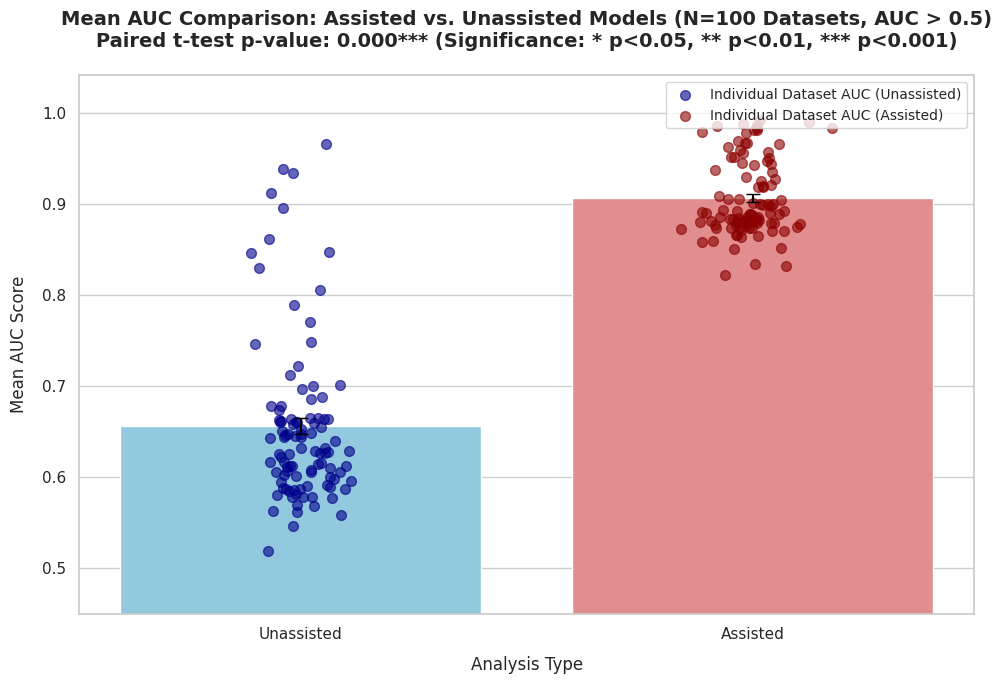


--- SVI vs. AUC Difference Analysis ---
SVI vs. AUC difference plot saved to analysis_figures_classification/svi_vs_auc_difference_aucgt0.5.png


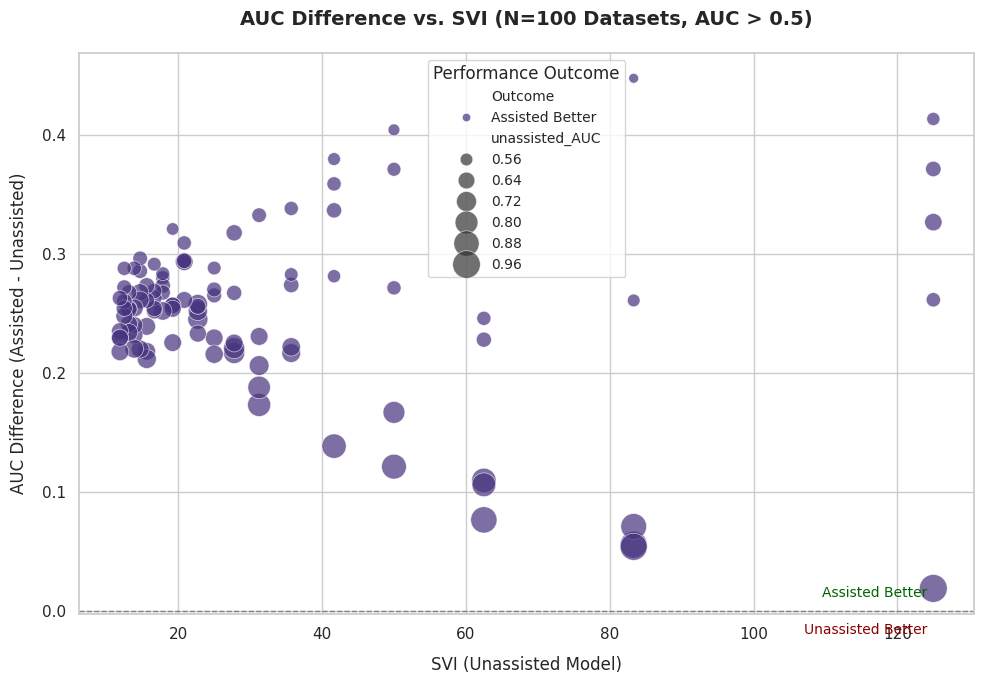


--- LLM Cluster AUC Distribution Plot ---


/tmp/ipykernel_52425/1037675154.py:313: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(
/tmp/ipykernel_52425/1037675154.py:327: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_sem_data = df_filtered.groupby('LLM Cluster Plot Label')['Mean_AUC'].agg(['mean', 'sem']).reset_index()


LLM Cluster AUC distribution plot saved to analysis_figures_classification/llm_cluster_auc_distribution_aucgt0.5.png


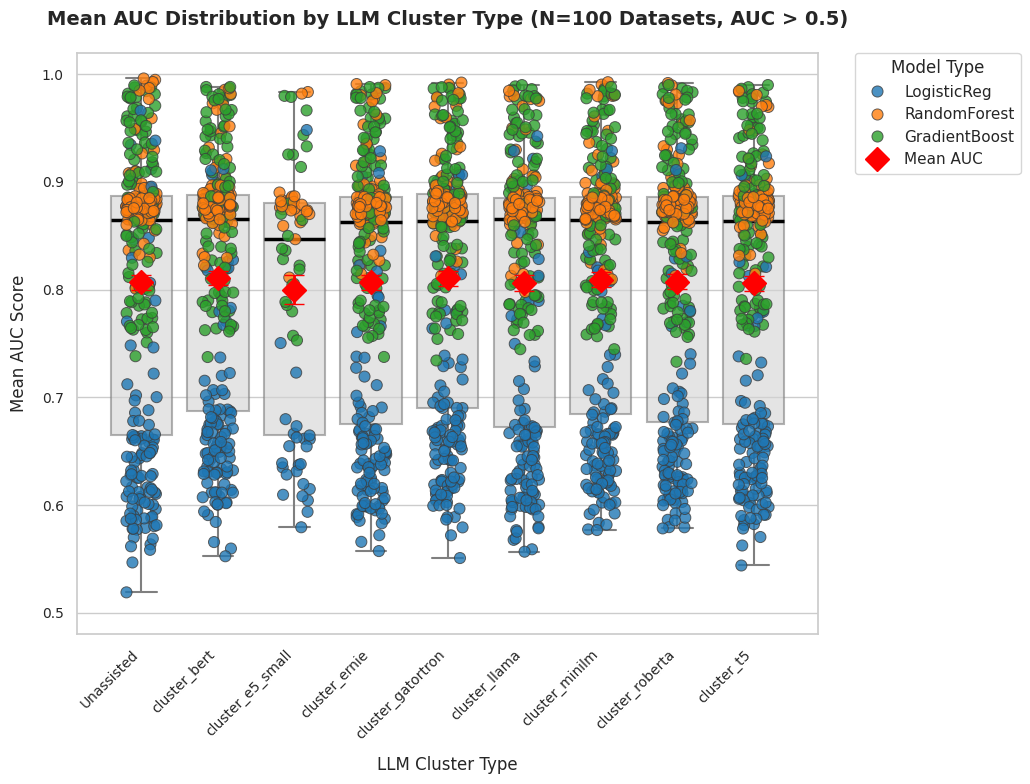


All analyses and plots complete. Check the 'analysis_figures_classification' directory.


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats # For statistical tests

# --- Configuration ---
# IMPORTANT: Updated RESULTS_FILE for classification output
RESULTS_FILE = "combined_classification_logistic_results.csv"
FIGURES_DIR = "analysis_figures_classification" # Directory for plots (new to avoid overwriting regression)

# Ensure the figures directory exists
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)
    print(f"Created directory: {FIGURES_DIR}")

# --- Helper Functions ---

def load_and_prepare_data(file_path):
    """
    Loads the results CSV, cleans it, and prepares for analysis.
    """
    if not os.path.exists(file_path):
        print(f"Error: Results file not found at {file_path}.")
        print(f"Please ensure '{RESULTS_FILE}' is in the same directory as this script.")
        return None

    df = pd.read_csv(file_path)

    # Ensure numeric types and handle NaNs for AUC and SVI
    df['Mean_AUC'] = pd.to_numeric(df['Mean_AUC'], errors='coerce')
    df['AUC_StdDev'] = pd.to_numeric(df['AUC_StdDev'], errors='coerce')
    df['SVI'] = pd.to_numeric(df['SVI'], errors='coerce')

    # Drop rows where essential metrics are NaN (e.g., if a model failed completely)
    df.dropna(subset=['Mean_AUC', 'SVI'], inplace=True)

    # --- FIX: Replace NaN in 'LLM_Cluster_Used' with 'Unassisted' ---
    # This is crucial for consistent plotting labels and to avoid type errors during sorting.
    df['LLM_Cluster_Used'] = df['LLM_Cluster_Used'].fillna('Unassisted')

    print(f"Loaded data from: {file_path}")
    print(f"Total rows after initial NaN drop for Mean_AUC/SVI: {len(df)}")
    return df

def get_paired_data(df):
    """
    Creates a paired DataFrame for Assisted vs. Unassisted comparison.
    For Assisted, it selects the best performing LLM cluster (by AUC) for each dataset.
    """
    # Filter for unassisted results
    unassisted_df = df[df['AnalysisType'] == 'Unassisted'].copy()
    
    # In the classification results, 'Mean_AUC' is the best model's AUC for 'Unassisted'
    # We need to select unique Dataset-Mean_AUC pairs.
    # Group by Dataset and Model, then take the first, or pick the best model if multiple are saved per dataset
    unassisted_paired = unassisted_df.groupby('Dataset').agg(
        unassisted_AUC=('Mean_AUC', 'first'), # Assuming Mean_AUC is already for the best model or pick one
        unassisted_AUC_std=('AUC_StdDev', 'first'),
        unassisted_SVI=('SVI', 'first')
    ).reset_index()

    # For assisted, find the best performing LLM cluster for each dataset (by Mean_AUC)
    assisted_df = df[df['AnalysisType'] == 'Assisted'].copy()
    
    # Group by Dataset and find the row with the maximum Mean_AUC (best assisted model for that dataset)
    best_assisted_per_dataset_idx = assisted_df.groupby('Dataset')['Mean_AUC'].idxmax()
    best_assisted_per_dataset = assisted_df.loc[best_assisted_per_dataset_idx]
    
    # Select relevant columns and rename for merging
    best_assisted_paired = best_assisted_per_dataset[[
        'Dataset', 'Mean_AUC', 'AUC_StdDev', 'SVI', 'LLM_Cluster_Used'
    ]].rename(columns={
        'Mean_AUC': 'assisted_AUC',
        'AUC_StdDev': 'assisted_AUC_std',
        'SVI': 'assisted_SVI',
        'LLM_Cluster_Used': 'best_LLM_cluster'
    })

    # Merge to get paired data
    paired_df = pd.merge(
        unassisted_paired,
        best_assisted_paired,
        on='Dataset',
        how='inner' # Only include datasets that have both unassisted and assisted results
    )
    
    # Calculate the difference in AUC
    paired_df['AUC_diff'] = paired_df['assisted_AUC'] - paired_df['unassisted_AUC']
    
    print(f"\nPaired data created. Initial paired datasets: {len(paired_df)}")
    return paired_df

def analyze_and_plot_paired_auc(paired_df, auc_threshold=0.5):
    """
    Performs paired analysis, describes row counts, and generates the comparison plot for AUC.
    """
    print("\n--- Paired Analysis: Assisted vs. Unassisted AUC ---")

    # 1. Describe row counts before and after filtering
    initial_unassisted_rows = paired_df['Dataset'].nunique()
    initial_assisted_rows = paired_df['Dataset'].nunique()
    
    print(f"Initial rows for paired analysis (before AUC threshold):")
    print(f"  Unassisted: {initial_unassisted_rows} datasets")
    print(f"  Assisted (best per dataset): {initial_assisted_rows} datasets")

    # Filter for valid AUC (good models: AUC > threshold, typically 0.5 for random)
    valid_paired_df = paired_df[
        (paired_df['unassisted_AUC'] > auc_threshold) &
        (paired_df['assisted_AUC'] > auc_threshold)
    ].copy()

    filtered_unassisted_rows = valid_paired_df['Dataset'].nunique()
    filtered_assisted_rows = valid_paired_df['Dataset'].nunique()

    print(f"\nRows after filtering for AUC > {auc_threshold}:")
    print(f"  Unassisted: {filtered_unassisted_rows} datasets")
    print(f"  Assisted (best per dataset): {filtered_assisted_rows} datasets")

    if valid_paired_df.empty:
        print("No valid datasets remaining after AUC thresholding for paired analysis. Skipping plot and t-test.")
        return

    # 2. Generate p-value (paired t-test)
    t_stat, p_value = stats.ttest_rel(valid_paired_df['assisted_AUC'], valid_paired_df['unassisted_AUC'])

    print(f"\nPaired t-test (Assisted AUC vs. Unassisted AUC) for AUC > {auc_threshold}:")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f}")

    # Determine significance stars for plot
    sig_stars = ""
    if p_value < 0.001:
        sig_stars = "***"
    elif p_value < 0.01:
        sig_stars = "**"
    elif p_value < 0.05:
        sig_stars = "*"

    # 3. Visualization: Bar plot with scatter overlay and Mean/SEM
    sns.set_theme(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 7))

    # Prepare data for plotting means and SEM
    plot_data = pd.DataFrame({
        'Type': ['Unassisted', 'Assisted'],
        'Mean_AUC': [valid_paired_df['unassisted_AUC'].mean(), valid_paired_df['assisted_AUC'].mean()],
        'SEM_AUC': [
            valid_paired_df['unassisted_AUC'].sem(), # Standard Error of the Mean
            valid_paired_df['assisted_AUC'].sem()
        ]
    })

    bar_plot = sns.barplot(
        data=plot_data,
        x='Type',
        y='Mean_AUC',
        hue='Type', # Explicitly map hue to 'Type'
        palette=['skyblue', 'lightcoral'],
        errorbar=None,
        legend=False,
        zorder=1
    )

    x_jitter_unassisted = np.random.normal(bar_plot.patches[0].get_x() + bar_plot.patches[0].get_width() / 2, 0.05, len(valid_paired_df))
    x_jitter_assisted = np.random.normal(bar_plot.patches[1].get_x() + bar_plot.patches[1].get_width() / 2, 0.05, len(valid_paired_df))

    plt.scatter(x_jitter_unassisted, valid_paired_df['unassisted_AUC'], color='darkblue', alpha=0.6, s=50, zorder=2, label='Individual Dataset AUC (Unassisted)')
    plt.scatter(x_jitter_assisted, valid_paired_df['assisted_AUC'], color='darkred', alpha=0.6, s=50, zorder=2, label='Individual Dataset AUC (Assisted)')

    plt.errorbar(
        x=plot_data['Type'],
        y=plot_data['Mean_AUC'],
        yerr=plot_data['SEM_AUC'],
        fmt='none',
        capsize=5,
        color='black',
        linewidth=1.5,
        zorder=3
    )

    plt.xlabel(f"Analysis Type", fontsize=12, labelpad=10)
    plt.ylabel("Mean AUC Score", fontsize=12, labelpad=10)
    
    # Title includes N datasets and p-value with significance stars explanation
    title_text = f"Mean AUC Comparison: Assisted vs. Unassisted Models (N={len(valid_paired_df)} Datasets, AUC > {auc_threshold})"
    title_text += f"\nPaired t-test p-value: {p_value:.3f}{sig_stars}"
    if sig_stars:
        title_text += f" (Significance: * p<0.05, ** p<0.01, *** p<0.001)"
    
    plt.title(title_text, fontsize=14, fontweight='bold', pad=20)

    plt.ylim(bottom=min(0.5, valid_paired_df['unassisted_AUC'].min(), valid_paired_df['assisted_AUC'].min()) - 0.05) # AUC typically starts from 0.5
    plt.legend(loc='upper right', fontsize=10)
    plt.tight_layout()

    fig_path = os.path.join(FIGURES_DIR, f"assisted_vs_unassisted_auc_comparison_p{p_value:.3f}.png")
    plt.savefig(fig_path, dpi=600, format='png')
    print(f"Comparison plot saved to {fig_path}")
    plt.show()
    plt.close()

def plot_svi_vs_auc_difference(paired_df, auc_threshold=0.5):
    """
    Explores the relationship between SVI and AUC difference (Assisted - Unassisted).
    """
    print("\n--- SVI vs. AUC Difference Analysis ---")

    valid_paired_df = paired_df[
        (paired_df['unassisted_AUC'] > auc_threshold) &
        (paired_df['assisted_AUC'] > auc_threshold)
    ].copy()

    if valid_paired_df.empty:
        print("No valid datasets remaining after AUC thresholding for SVI analysis. Skipping plot.")
        return

    valid_paired_df['Outcome'] = np.where(valid_paired_df['AUC_diff'] > 0, 'Assisted Better', 'Unassisted Better or Equal')

    sns.set_theme(style="whitegrid", palette="viridis")
    plt.figure(figsize=(10, 7))

    scatter_plot = sns.scatterplot(
        data=valid_paired_df,
        x='unassisted_SVI',
        y='AUC_diff',
        hue='Outcome',
        size='unassisted_AUC', # Size points by unassisted AUC to give context
        sizes=(50, 400),
        alpha=0.7,
        edgecolor='w',
        linewidth=0.5,
        zorder=2
    )

    plt.axhline(0, color='gray', linestyle='--', linewidth=1, zorder=1)

    xlim = plt.xlim()
    plt.text(xlim[1] * 0.95, 0.01, 'Assisted Better', va='bottom', ha='right', color='darkgreen', fontsize=10)
    plt.text(xlim[1] * 0.95, -0.01, 'Unassisted Better', va='top', ha='right', color='darkred', fontsize=10)


    plt.xlabel("SVI (Unassisted Model)", fontsize=12, labelpad=10)
    plt.ylabel("AUC Difference (Assisted - Unassisted)", fontsize=12, labelpad=10)
    plt.title(f"AUC Difference vs. SVI (N={len(valid_paired_df)} Datasets, AUC > {auc_threshold})", fontsize=14, fontweight='bold', pad=20)
    
    plt.legend(title="Performance Outcome", loc='best', fontsize=10)
    plt.tight_layout()

    fig_path = os.path.join(FIGURES_DIR, f"svi_vs_auc_difference_aucgt{auc_threshold}.png")
    plt.savefig(fig_path, dpi=600, format='png')
    print(f"SVI vs. AUC difference plot saved to {fig_path}")
    plt.show()
    plt.close()

def plot_llm_cluster_auc_distribution(df, auc_threshold=0.5):
    """
    Generates a dot and whisker plot (boxplot with individual points)
    showing AUC distribution for each LLM cluster type and Unassisted.
    """
    print("\n--- LLM Cluster AUC Distribution Plot ---")

    # Filter for models that meet the AUC threshold (e.g., AUC > 0.5)
    # This plot shows individual model performances, so we filter the raw df
    df_filtered = df[df['Mean_AUC'] > auc_threshold].copy()

    if df_filtered.empty:
        print(f"No data points with Mean_AUC > {auc_threshold} to plot for LLM cluster distribution.")
        return

    # --- FIX: Replace NaN in 'LLM_Cluster_Used' with 'Unassisted' for plotting clarity ---
    # This was already done in load_and_prepare_data, but good to ensure here if this function
    # were ever called independently. For now, it's redundant but harmless.
    # df_filtered['LLM_Cluster_Used'] = df_filtered['LLM_Cluster_Used'].fillna('Unassisted')
    
    # Use the already cleaned 'LLM_Cluster_Used' column directly
    df_filtered['LLM Cluster Plot Label'] = df_filtered['LLM_Cluster_Used']
    
    # Get unique cluster names, ensuring they are strings and removing any potential NaNs
    unique_clusters = [str(c) for c in df_filtered['LLM Cluster Plot Label'].unique() if pd.notna(c)]
    
    # Order the LLM clusters for consistent plotting
    # Ensure 'Unassisted' is always first if present
    if 'Unassisted' in unique_clusters:
        unique_clusters.remove('Unassisted')
    unique_clusters.sort() # Sort other cluster names alphabetically
    ordered_clusters = ['Unassisted'] + unique_clusters

    # Ensure the plot labels are in the desired order
    df_filtered['LLM Cluster Plot Label'] = pd.Categorical(df_filtered['LLM Cluster Plot Label'], categories=ordered_clusters, ordered=True)

    # --- Adjust visibility of boxplot elements and stripplot dots ---
    sns.set_theme(style="whitegrid", palette="tab10")
    plt.figure(figsize=(12, 8))

    # Create a boxplot to show distribution (median, quartiles, whiskers)
    sns.boxplot(
        data=df_filtered,
        x='LLM Cluster Plot Label',
        y='Mean_AUC',
        color="lightgray",
        showfliers=False,
        boxprops=dict(alpha=0.6, linewidth=1.5), # Increased linewidth
        medianprops=dict(color='black', linewidth=2.5), # Increased linewidth
        whiskerprops=dict(linewidth=1.5), # Increased linewidth
        capprops=dict(linewidth=1.5), # Increased linewidth
        zorder=1
    )

    # Overlay individual data points (dots)
    sns.stripplot(
        data=df_filtered,
        x='LLM Cluster Plot Label',
        y='Mean_AUC',
        hue='Model',
        jitter=0.2,
        alpha=0.8, # Increased alpha for better visibility
        size=8, # Increased dot size
        linewidth=0.7, # Increased dot outline width
        edgecolor='gray',
        zorder=2
    )
    
    # Add mean and standard error of the mean (SEM) as an overlay
    mean_sem_data = df_filtered.groupby('LLM Cluster Plot Label')['Mean_AUC'].agg(['mean', 'sem']).reset_index()
    
    plt.plot(
        mean_sem_data['LLM Cluster Plot Label'],
        mean_sem_data['mean'],
        marker='D',
        markersize=12, # Increased marker size
        linestyle='none',
        color='red',
        label='Mean AUC',
        zorder=3
    )
    
    plt.errorbar(
        mean_sem_data['LLM Cluster Plot Label'],
        mean_sem_data['mean'],
        yerr=mean_sem_data['sem'],
        fmt='none',
        color='red',
        capsize=7, # Increased capsize
        linewidth=2, # Increased linewidth
        zorder=3
    )

    plt.xlabel("LLM Cluster Type", fontsize=12, labelpad=10)
    plt.ylabel("Mean AUC Score", fontsize=12, labelpad=10)
    num_datasets_plotted_llm_dist = df_filtered['Dataset'].nunique()
    plt.title(f"Mean AUC Distribution by LLM Cluster Type (N={num_datasets_plotted_llm_dist} Datasets, AUC > {auc_threshold})", fontsize=14, fontweight='bold', pad=20)
    
    plt.ylim(bottom=0.5 - 0.02)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Model Type", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.88, 1])

    fig_path = os.path.join(FIGURES_DIR, f"llm_cluster_auc_distribution_aucgt{auc_threshold}.png")
    plt.savefig(fig_path, dpi=600, format='png')
    print(f"LLM Cluster AUC distribution plot saved to {fig_path}")
    plt.show()
    plt.close()


# --- Main Execution ---
def main():
    df_combined = load_and_prepare_data(RESULTS_FILE)
    if df_combined is None:
        return

    # Get paired data for comparison (Assisted vs Unassisted)
    # This requires filtering to get the 'best' assisted model per dataset
    paired_df = get_paired_data(df_combined)
    if paired_df.empty:
        print("No paired datasets found for Assisted vs Unassisted comparison. Exiting.")
        # Still proceed with other plots if desired, just not this one
    else:
        # Analyze and plot paired AUC comparison
        # You can adjust the auc_threshold here. Default is 0.5.
        analyze_and_plot_paired_auc(paired_df, auc_threshold=0.5)

        # Explore SVI relationship
        plot_svi_vs_auc_difference(paired_df, auc_threshold=0.5)

    # Generate dot and whisker plot by type of LLM (all models, all clusters)
    # This plot uses the full df_combined, not just the paired_df
    plot_llm_cluster_auc_distribution(df_combined, auc_threshold=0.5)

    print("\nAll analyses and plots complete. Check the 'analysis_figures_classification' directory.")

if __name__ == "__main__":
    main()

In [49]:
pd.read_csv("combined_classification_logistic_results.csv")

,Dataset,AnalysisType,LLM_Cluster_Used,Model,Mean_AUC,AUC_StdDev,SVI,TopFeatures
0,data_79_quadratic,Unassisted,NaN,LogisticReg,0.596246,0.068053,14.705882,NaN
1,data_79_quadratic,Unassisted,NaN,RandomForest,0.872779,0.036477,14.705882,NaN
2,data_79_quadratic,Unassisted,NaN,GradientBoost,0.898231,0.049076,14.705882,NaN
3,data_79_quadratic,Assisted,cluster_gatortron,LogisticReg,0.622546,0.061297,14.285714,NaN
4,data_79_quadratic,Assisted,cluster_gatortron,RandomForest,0.877883,0.035438,14.285714,NaN
...,...,...,...,...,...,...,...,...
2446,data_28_linear,Assisted,cluster_ernie,RandomForest,0.876760,0.038173,33.333333,NaN
2447,data_28_linear,Assisted,cluster_ernie,GradientBoost,0.904931,0.039528,33.333333,NaN
2448,data_28_linear,Assisted,cluster_llama,LogisticReg,0.678736,0.053459,33.333333,NaN
2449,data_28_linear,Assisted,cluster_llama,RandomForest,0.882659,0.034601,33.333333,NaN


In [51]:
#to write file to html
import nbformat
from nbconvert import HTMLExporter

# Load your notebook
with open("Academic synthetic data.ipynb") as f:
    nb = nbformat.read(f, as_version=4)

# Convert to HTML
exporter = HTMLExporter()
body, _ = exporter.from_notebook_node(nb)

# Write the HTML to a file
with open("Academic synthetic data.html", "w") as f:
    f.write(body)
